<h2 style="color:#1616a7" align='center'> Midterm Project: Research on ETF intraday volatility vs volume </h2>

### Lakshmi Priya Ramisetty - lramiset@mail.yu.edu
### Namrataben Patel- npatel13@mail.yu.edu
### Pinal Gajjar- pgajjar@mail.yu.edu

<h3 style="color:#1616a7">1. Research on ETF intraday volatility vs volume</h3>

In [1]:
#Import the useful packages
import pandas as pd
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# plt.rcParams["figure.figsize"] = [25, 20]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
class HandleDataFrame:

    def __init__(self, symbol):
        self.Symbol = symbol
    
    def load_data(self,period):
        return yf.download(self.Symbol,period=period)
        
    def calculate_volatility_volume(self,df):
        # Fill the NULL values
        df = df.fillna(method='bfill')
        # Compute the intraday volatility as Volatility = (High-Low)/Close
        df['Volatility'] = (df['High'] - df['Low']) / df['Close']

        # Compute the daily volume change as Volume_delta = Volume_today - Volume_previousday
        df['Volume_delta'] = df['Volume'].diff()

        # Compute the daily volatility change as Volatility_delta = Volatility_today - Volatility_previousday
        df['Volatility_delta'] = df['Volatility'].diff()

        # Data Cleaning
        # Fill missing values in the 'Volume_delta' using bfill.
        df['Volume_delta'] = df['Volume_delta'].fillna(method='bfill')

        # Fill missing values in the 'Volatility_delta' using bfill.
        df['Volatility_delta'] = df['Volatility_delta'].fillna(method='bfill')
        
        return df

    def plot_delta(self, df):
        # Plot Volume_delta and Volatility_delta

        df.plot(x='Volume_delta', y='Volatility_delta', style='.', title='Scatter Plot of Volume_delta vs. Volatility_delta')
        plt.xlabel('Volume Delta')
        plt.ylabel('Volatility Delta')

        # Show the plot
        plt.show()

In [3]:
class Evaluation:
    def __init__(self, observed_values, predicted_values):
        self.observed_values = observed_values
        self.predicted_values = predicted_values
        
    def calculate_rmse(self):
        observed_values = self.observed_values
        predicted_values = self.predicted_values
        squared_errors = [(actual - predicted) ** 2 for actual, predicted in zip(observed_values, predicted_values)]
        mse = np.mean(squared_errors)
        rmse = np.sqrt(mse)
        
        return rmse
      
    def residual_plot(self, ax):
        observed_values = self.observed_values
        predicted_values = self.predicted_values
        residuals = [observed - predicted for observed, predicted in zip(observed_values, predicted_values)]

        # Create a scatter plot of residuals
        ax.scatter(range(len(residuals)), residuals, label='Residuals', c='blue')

        # Add a horizontal line at y=0 for reference
        ax.axhline(0, color='red', linestyle='--', label='Zero Residual Line')

        # Set labels and legend
        ax.set_xlabel('Data Point', fontsize = 20, color = 'r')
        ax.set_ylabel('Residual', fontsize = 20, color = 'r')
        ax.legend()
        
    def pred_vs_actual_plot(self, ax):
        observed_values = self.observed_values
        predicted_values = self.predicted_values
        
        # Create a scatter plot of observed vs. predicted values
        ax.scatter(observed_values, predicted_values, c='blue', label='Observed vs. Predicted')

        # Add a 45-degree reference line
        ax.plot([min(observed_values), max(observed_values)], [min(observed_values), max(observed_values)], 'r', label='45-Degree Line', color='red')

        # Set labels and legend
        ax.set_xlabel('Observed Values', fontsize = 20, color = 'r')
        ax.set_ylabel('Predicted Values', fontsize = 20, color = 'r')
        ax.legend()

    
    def calculate_r2(self):
        observed_values = self.observed_values
        predicted_values = self.predicted_values
        mean_observed = sum(observed_values) / len(observed_values)
    
        # Calculate the total sum of squares (TSS)
        tss = sum((observed - mean_observed) ** 2 for observed in observed_values)

        # Calculate the residual sum of squares (RSS)
        rss = sum((observed - predicted) ** 2 for observed, predicted in zip(observed_values, predicted_values))

        # Calculate R-squared
        r_squared = 1 - (rss / tss)

        return r_squared
    

In [4]:
class Linear:
    def __init__(self, DF,symbol):
        self.DF = DF
        self.Symbol=symbol
    
    def linear_func(self, x, a, b):
        return a*x + b
        
    def linear_fit(self):
    
        # Fit the data to the linear model
        popt, _ = curve_fit(self.linear_func, self.DF.Volume, self.DF.Volatility)

        return popt
    
    def predicted_values(self, df, a, b):
        return self.linear_func(df.Volume, a, b)
    
    def plot_linear(self, df, a, b):
        plt.scatter(df.Volume, df.Volatility)
        x_vals = df.Volume
#         x_vals = np.arange(min(df.Volume), max(df.Volume), 1)
        y_vals = self.linear_func(x_vals, a, b)

        plt.title(f"Linear Fit: {self.Symbol} ({df.index.min().strftime('%b %d, %Y')}-{df.index.max().strftime('%b %d, %Y')})", fontsize=25, color="g")
        plt.plot(x_vals, y_vals, '--', color = 'r',label='Linear Fit')
        plt.xlabel("Volume", fontsize = 20, color = 'r')
        plt.ylabel("Volatility", fontsize = 20, color = 'r')
        plt.legend()
        #plt.show()

In [5]:
class Quadratic:
    def __init__(self, DF,symbol):
        self.DF = DF
        self.Symbol = symbol
        
    def quadratic_func(self, x, a, b, c):
         return a * x**2 + b * x + c
        
    def quadratic_fit(self):
        popt, _ = curve_fit(self.quadratic_func, self.DF.Volume, self.DF.Volatility)
        return popt
    
    def predicted_values(self, df, a, b, c):
        return self.quadratic_func(df.Volume, a, b, c)

    def plot_quadratic(self, df, a, b, c):
        plt.scatter(df.Volume, df.Volatility)
        x_vals = df.Volume
#         x_vals = np.arange(min(df.Volume), max(df.Volume), 1)
        y_vals = self.quadratic_func(x_vals,a,b,c)

        plt.title(f"Quadratic Fit: {self.Symbol} ({df.index.min().strftime('%b %d, %Y')}-{df.index.max().strftime('%b %d, %Y')})",  fontsize=30, color="g")
        plt.plot(x_vals, y_vals, '--', color = 'r',label='Quadratic Fit')
        plt.xlabel("Volume", fontsize = 20, color = 'r')
        plt.ylabel("Volatility", fontsize = 20, color = 'r')
        plt.legend()
       

In [6]:
class Cubic:
    def __init__(self, DF,symbol):
        self.DF = DF
        self.Symbol = symbol
        
    def cubic_func(self, x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

        
    def cubic_fit(self):
        popt, _ = curve_fit(self.cubic_func, self.DF.Volume, self.DF.Volatility)
        return popt
    
    def predicted_values(self, df, a, b, c, d):
        return self.cubic_func(df.Volume, a, b, c, d)
    
    def plot_cubic(self, df, a, b, c, d):
        plt.scatter(df.Volume, df.Volatility)
        x_vals = df.Volume
#         x_vals = np.arange(min(df.Volume), max(df.Volume), 1)
        y_vals = self.cubic_func(x_vals,a,b,c,d)

        plt.title(f"Cubic Fit: {self.Symbol} ({df.index.min().strftime('%b %d, %Y')}-{df.index.max().strftime('%b %d, %Y')})",  fontsize=30, color="g")
        plt.plot(x_vals, y_vals, '--', color = 'r',label='Cubit Fit')
        plt.xlabel("Volume", fontsize = 20, color = 'r')
        plt.ylabel("Volatility", fontsize = 20, color = 'r')
        plt.legend()

In [7]:
class Quartic:
    def __init__(self, DF,symbol):
        self.DF = DF
        self.Symbol = symbol
        
    def quartic_func(self, x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e

    def quartic_fit(self):
        popt, _ = curve_fit(self.quartic_func, self.DF.Volume, self.DF.Volatility)
        return popt
    
    def predicted_values(self, df, a, b, c, d, e):
        return self.quartic_func(df.Volume, a, b, c, d, e)
    
    def plot_quartic(self, df, a, b, c, d, e):
        plt.scatter(df.Volume, df.Volatility)
        x_vals = df.Volume
#         x_vals = np.arange(min(df.Volume), max(df.Volume), 1)
        y_vals = self.quartic_func(x_vals,a,b,c,d, e)

        plt.title(f"Quartic Fit: {self.Symbol} ({df.index.min().strftime('%b %d, %Y')}-{df.index.max().strftime('%b %d, %Y')})",  fontsize=30, color="g")
        plt.plot(x_vals, y_vals, '--', color = 'r', label='Quartic Fit')
        plt.xlabel("Volume", fontsize = 20, color = 'r')
        plt.ylabel("Volatility", fontsize = 20, color = 'r')
        plt.legend()
        

In [8]:
# Object to handle SPY data
spy = HandleDataFrame('SPY')

In [9]:
# Load SPY 1 year data
spy_1y = spy.load_data("1Y")
spy_1y = spy.calculate_volatility_volume(spy_1y)
spy_1y.head()


[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-11-04  377.000000  378.869995  370.000000  376.350006  370.517242   
2022-11-07  377.709991  380.570007  375.529999  379.950012  374.061432   
2022-11-08  381.109985  385.119995  377.720001  382.000000  376.079681   
2022-11-09  379.929993  381.140015  373.609985  374.130005  368.331696   
2022-11-10  388.049988  395.040009  385.640015  394.690002  388.572998   

               Volume  Volatility  Volume_delta  Volatility_delta  
Date                                                               
2022-11-04  103505200    0.023568   -35218300.0         -0.010304  
2022-11-07   68286900    0.013265   -35218300.0         -0.010304  
2022-11-08   84641100    0.019372    16354200.0          0.006107  
2022-11-09   78495500    0.020127    -6145600.0          0.000755  
2022-11-10  141455800    0.023816    62960300.0          0.003689

In [10]:
# Load SPY 5 year data
spy_5y = spy.load_data("5Y")
spy_5y = spy.calculate_volatility_volume(spy_5y)
spy_5y.head()

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-11-05  272.440002  274.010010  271.350006  273.390015  251.499847   
2018-11-06  273.320007  275.299988  273.250000  275.119995  253.091309   
2018-11-07  277.559998  281.100006  277.079987  281.010010  258.509766   
2018-11-08  280.109985  281.220001  279.220001  280.500000  258.040558   
2018-11-09  279.029999  279.239990  276.179993  277.760010  255.519913   

               Volume  Volatility  Volume_delta  Volatility_delta  
Date                                                               
2018-11-05   65622500    0.009730    -5536600.0         -0.002278  
2018-11-06   60085900    0.007451    -5536600.0         -0.002278  
2018-11-07  102752100    0.014306    42666200.0          0.006854  
2018-11-08   65584900    0.007130   -37167200.0         -0.007175  
2018-11-09   98812600    0.011017    33227700.0          0.003887

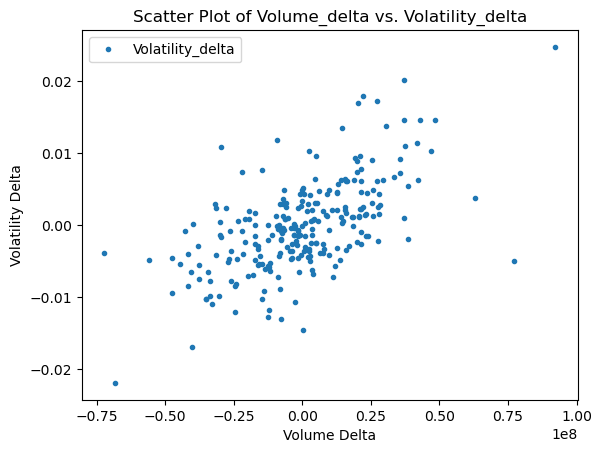

In [11]:
# Plot Volume_delta and Volatility_delta for 1Y
spy.plot_delta(spy_1y)

<h2 align ='center'>Fitting Equations for SPY</h2>

Our Linear Fit Equation is y = 1.5719183070618465e-10 * x + -0.0013435837683563585 

Our Quadratic Fit Equation is y = -5.345395537126208e-19 * x**2 + 2.603966385348698e-10 * x + -0.005972102144452449 

Our Cubic Fit Equation is y = 3.944235758823032e-23 * x**3 + -5.286605476283894e-19 * x**2 + :2.602300142756462e-10 * x + -0.006005585940491182 

Our Quartic Fit Equation is y = 5.308705742740746e-24 * x**4 + 3.940856150653972e-23 * x**3 + :-5.292278738600412e-19 * x**2 + 2.60277763660431e-10 * x + -0.006005469846399192 



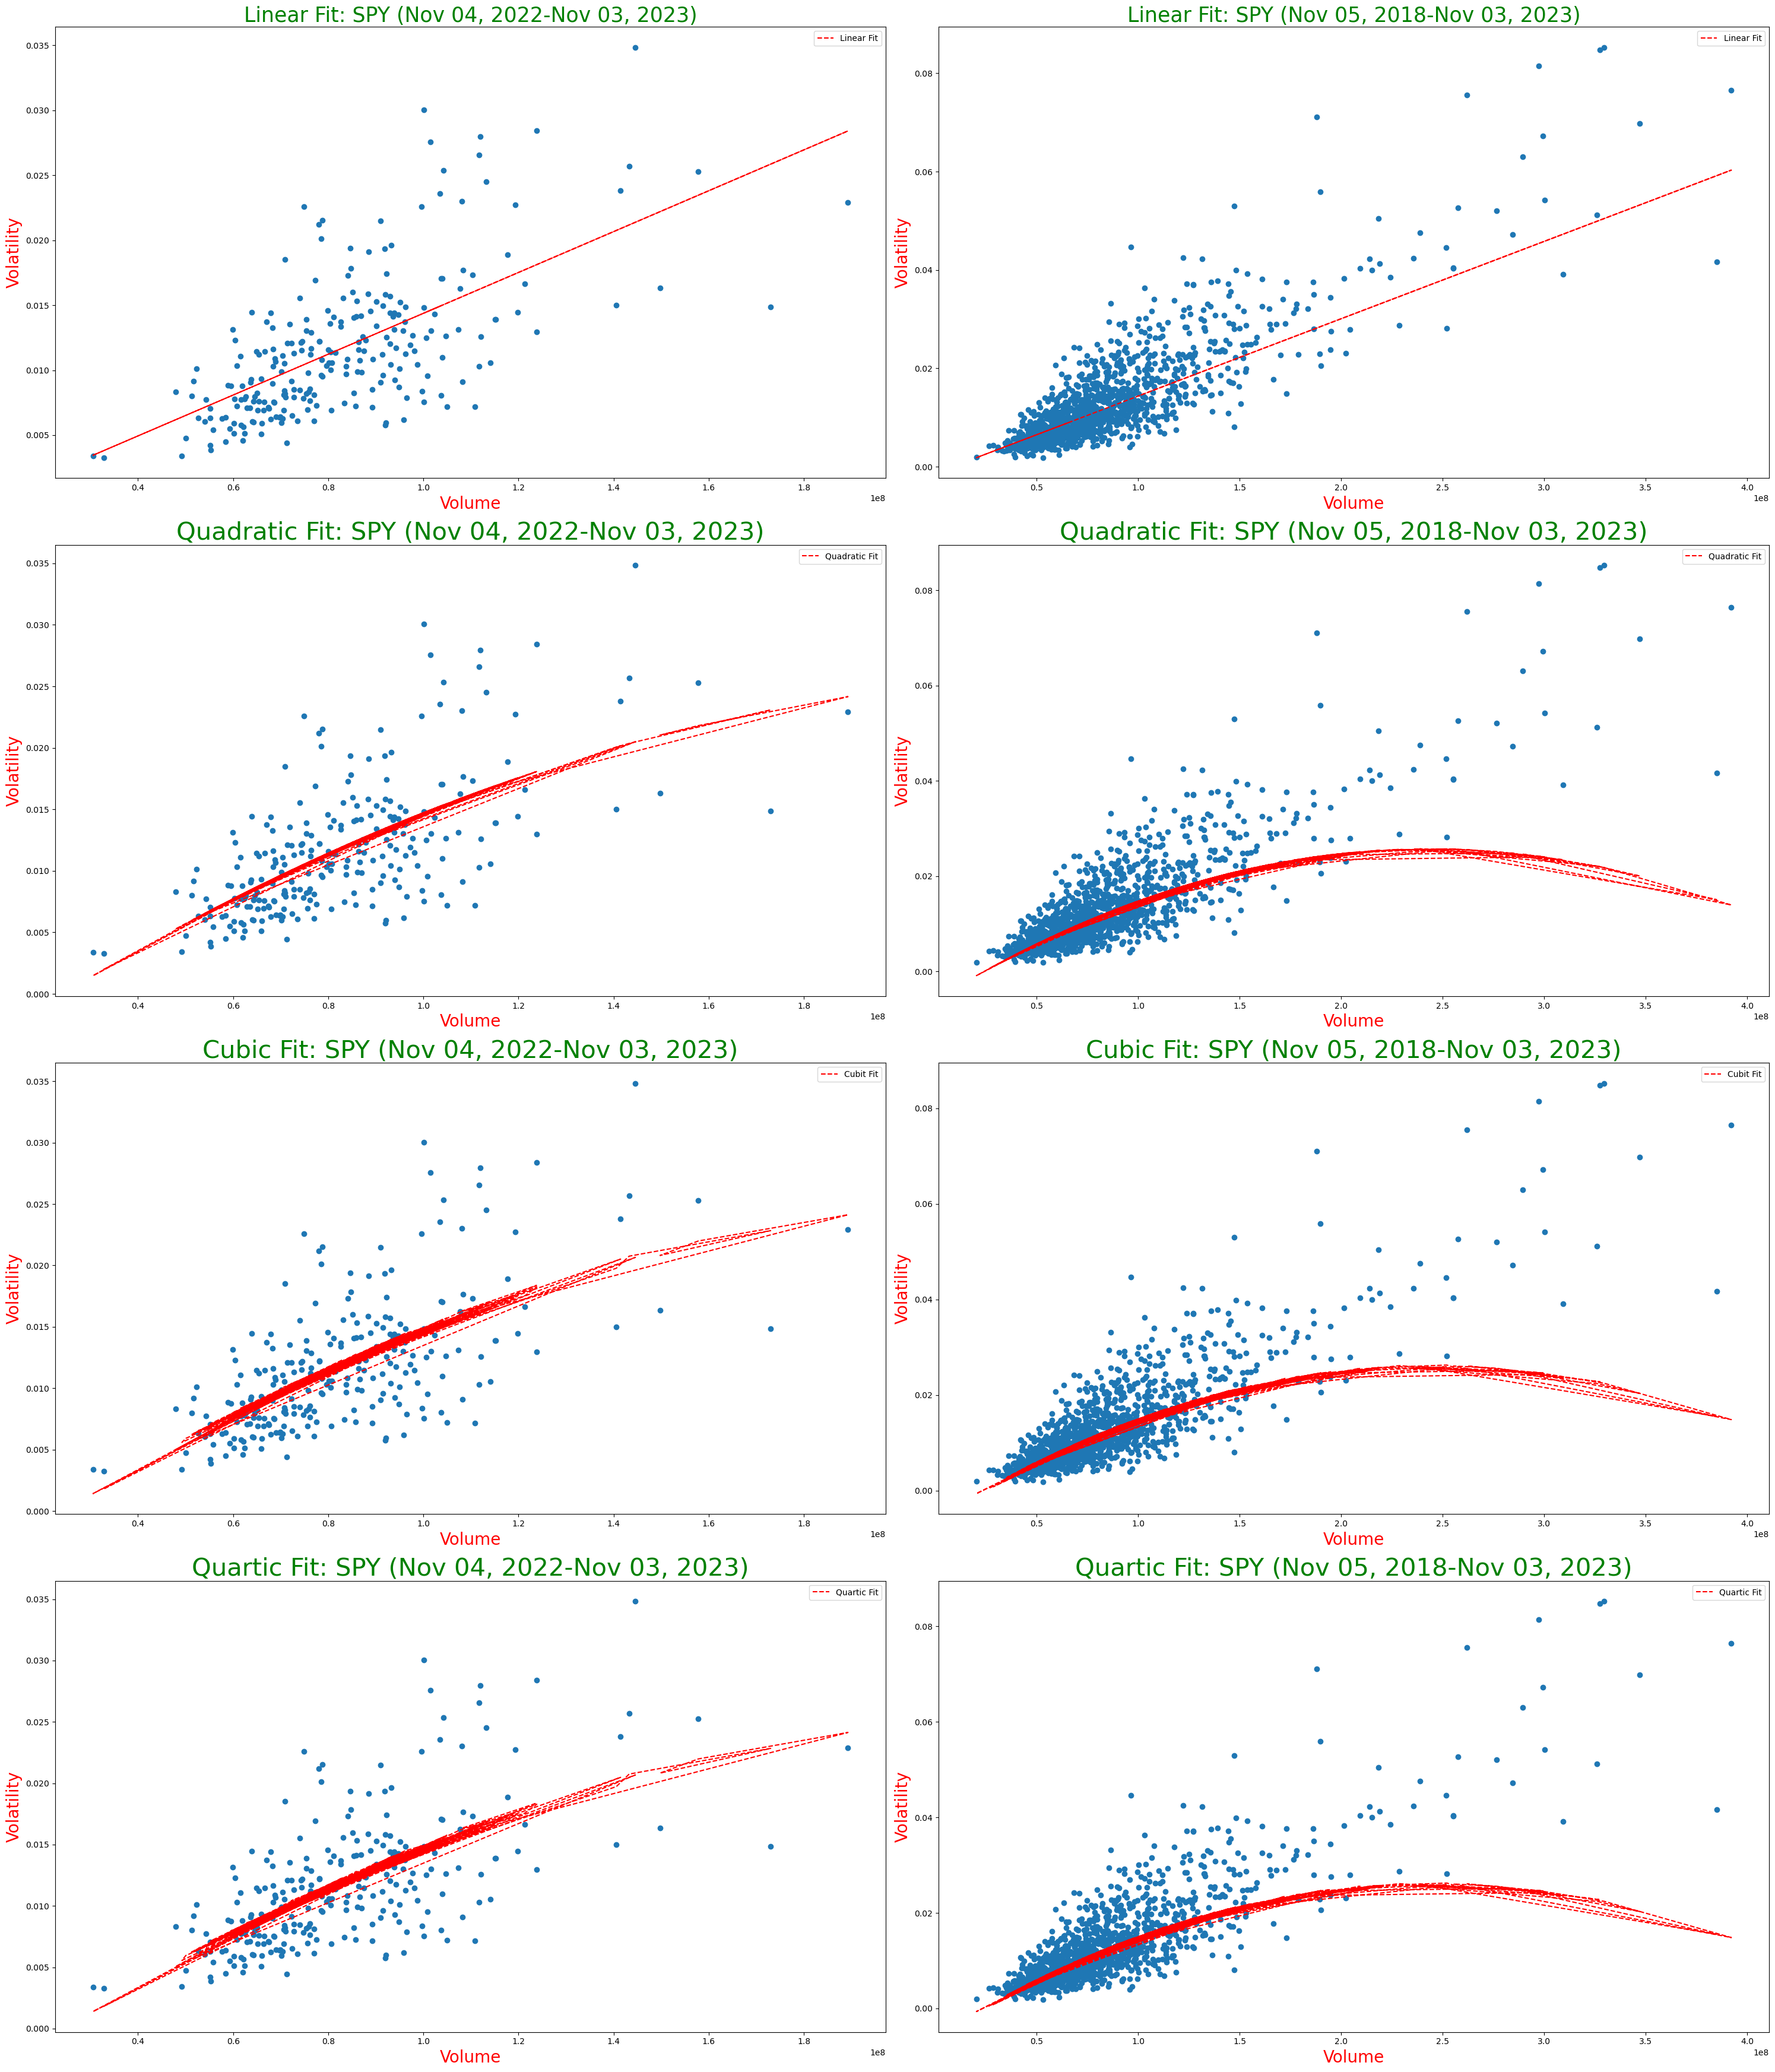

In [12]:
# SPY 1Y Linear equation
spy_linearfit = Linear(spy_1y,'SPY')
lin_a, lin_b = spy_linearfit.linear_fit()
print(f"Our Linear Fit Equation is y = {lin_a} * x + {lin_b} \n")

# SPY 1Y Quadratic equation
spy_quadraticfit = Quadratic(spy_1y,'SPY')
quad_a, quad_b, quad_c = spy_quadraticfit.quadratic_fit()
# Print the equation
print(f"Our Quadratic Fit Equation is y = {quad_a} * x**2 + {quad_b} * x + {quad_c} \n")

# SPY 1Y Cubic equation
spy_cubicfit = Cubic(spy_1y,'SPY')
cub_a, cub_b, cub_c, cub_d = spy_cubicfit.cubic_fit()
print(f"Our Cubic Fit Equation is y = {cub_a} * x**3 + {cub_b} * x**2 + :{cub_c} * x + {cub_d} \n")

# SPY 1Y Quartic equation
spy_quarticfit = Quartic(spy_1y,'SPY')
quar_a, quar_b, quar_c, quar_d, quar_e = spy_quarticfit.quartic_fit()
print(f"Our Quartic Fit Equation is y = {quar_a} * x**4 + {quar_b} * x**3 + :{quar_c} * x**2 + {quar_d} * x + {quar_e} \n")


# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Plot Linear Fit
plt.subplot(421)
spy_linearfit.plot_linear(spy_1y, lin_a, lin_b)

plt.subplot(422)
spy_linearfit.plot_linear(spy_5y, lin_a, lin_b)


# Plot Quadratic fit
plt.subplot(423)
spy_quadraticfit.plot_quadratic(spy_1y, quad_a, quad_b, quad_c)

plt.subplot(424)
spy_quadraticfit.plot_quadratic(spy_5y, quad_a, quad_b, quad_c)


# Plot Cubic fit
plt.subplot(425)
spy_cubicfit.plot_cubic(spy_1y, cub_a, cub_b, cub_c, cub_d)

plt.subplot(426)
spy_cubicfit.plot_cubic(spy_5y, cub_a, cub_b, cub_c, cub_d)


# Plot Quartic fit
plt.subplot(427)
spy_quarticfit.plot_quartic(spy_1y, quar_a, quar_b, quar_c, quar_d, quar_e)

plt.subplot(428)
spy_quarticfit.plot_quartic(spy_5y, quar_a, quar_b, quar_c, quar_d, quar_e)

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

| FIT | 1 YEAR | 5 YEARS | FINAL THOUGHTS |
| :- | :-: | :-: | :-: |
| Linear |We can observe that the data points are somewhat dispersed around the linear fit line. While they exhibit some variance, they generally maintain proximity to this line. |There is a noticeable change in the pattern. Data points are tightly clustered around the linear fit line, suggesting a robust fit to the 5-year data. The concentration of data points along the line indicates a strong linear relationship, and any remaining residuals appear to be evenly distributed. This pattern demonstrates a reliable fit to the extended 5-year data, affirming the validity of the linear model.|Our Linear Fit looks to be doing well when we tested it on the 5 Years data.|
| Quadratic |We observe a quadratic fit curve where all data points are evenly dispersed around the curve. This suggests that the data points are distributed uniformly and closely conform to the shape of the curve, indicating a good fit.| The quadratic fit curve exhibits a more pronounced curvature. Data points are clustered towards the lower-left portion of the plot and appear to follow an upward trajectory. This pattern signifies a more complex relationship between the variables and highlights a distinct deviation from the even distribution observed in the 1-year dataset.|Quadratic Fit is  not doing as well as Linear Fit.|
| Cubic |Cubic Fit shows similar pattern as quadratic fit equation.|Cubic Fit shows similar pattern as quadratic fit equation.| Cubic Fit is also not doing as well as Linear Fit. |
| Quartic |Quartic Fit shows similar pattern as quadratic fit equation.|Quartic Fit shows similar pattern as quadratic fit equation. |Quartic Fit is not doing as well as Linear Fit either.  |

Let's now check the Residual and Predicted vs Actual plots to analyse further.

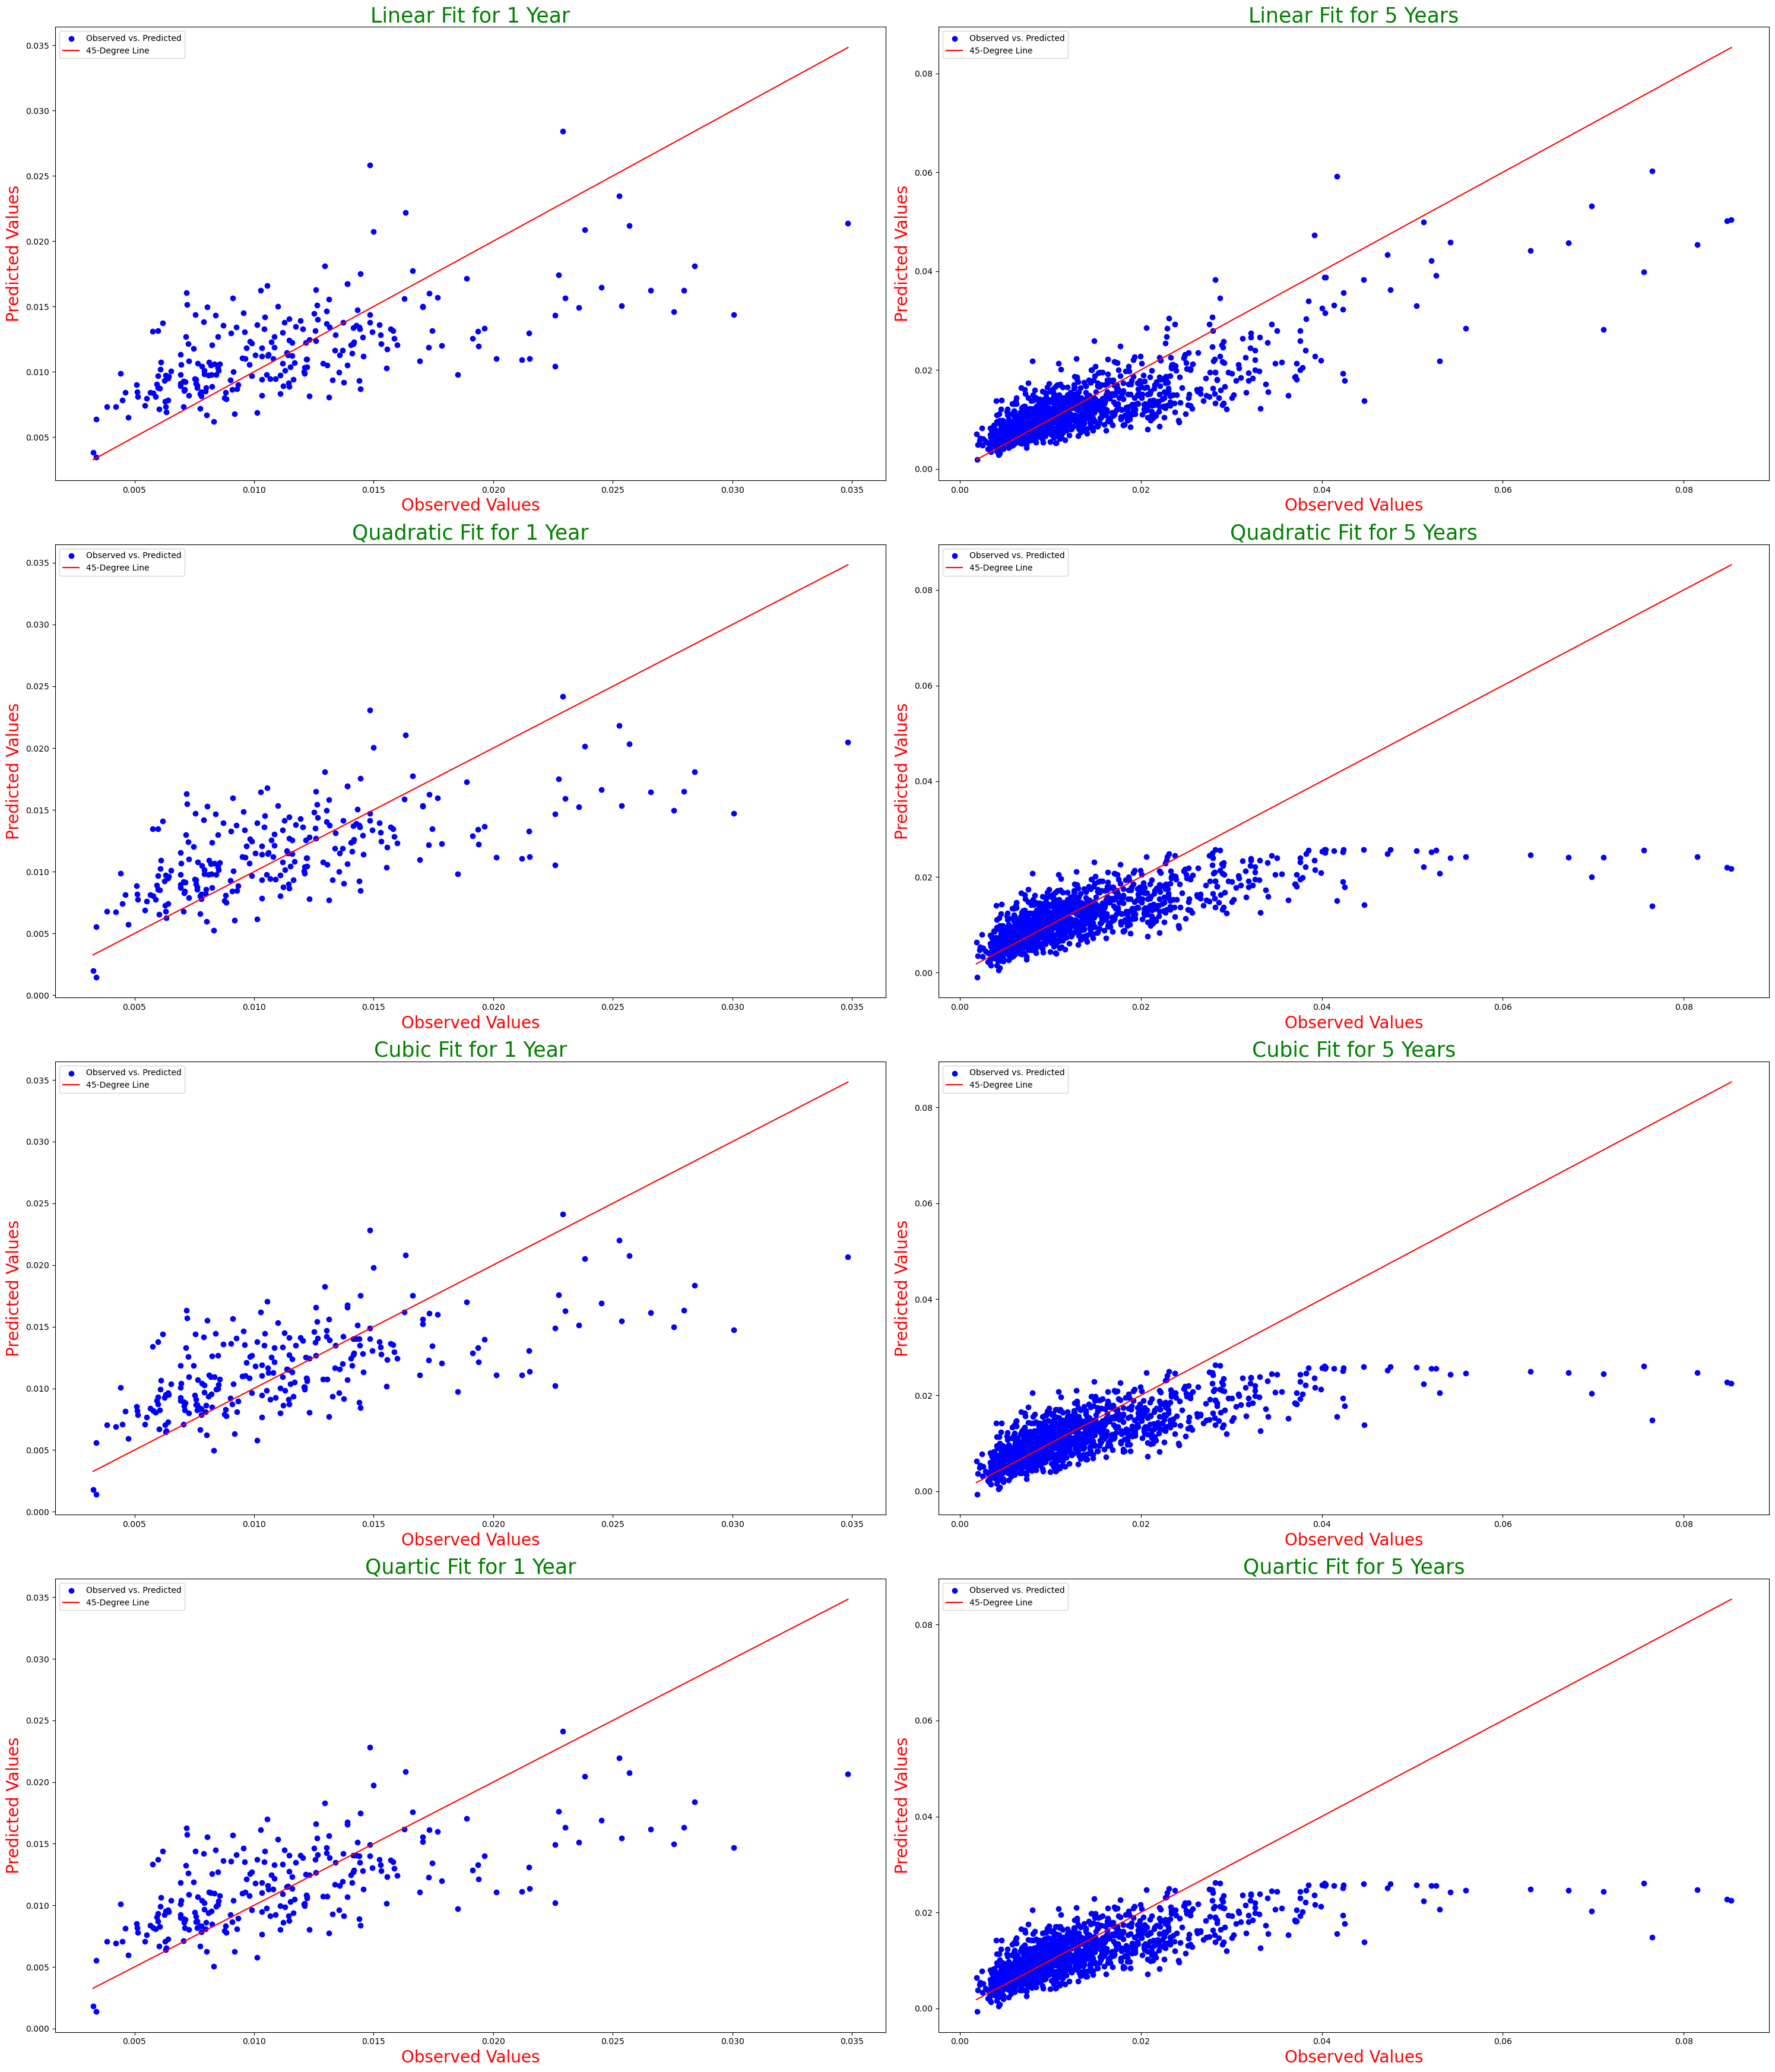

In [13]:
# Predicted vs Actual plot
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_linearfit.predicted_values(spy_1y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_linearfit.predicted_values(spy_5y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_quadraticfit.predicted_values(spy_1y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_quadraticfit.predicted_values(spy_5y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_cubicfit.predicted_values(spy_1y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_cubicfit.predicted_values(spy_5y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_quarticfit.predicted_values(spy_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_quarticfit.predicted_values(spy_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


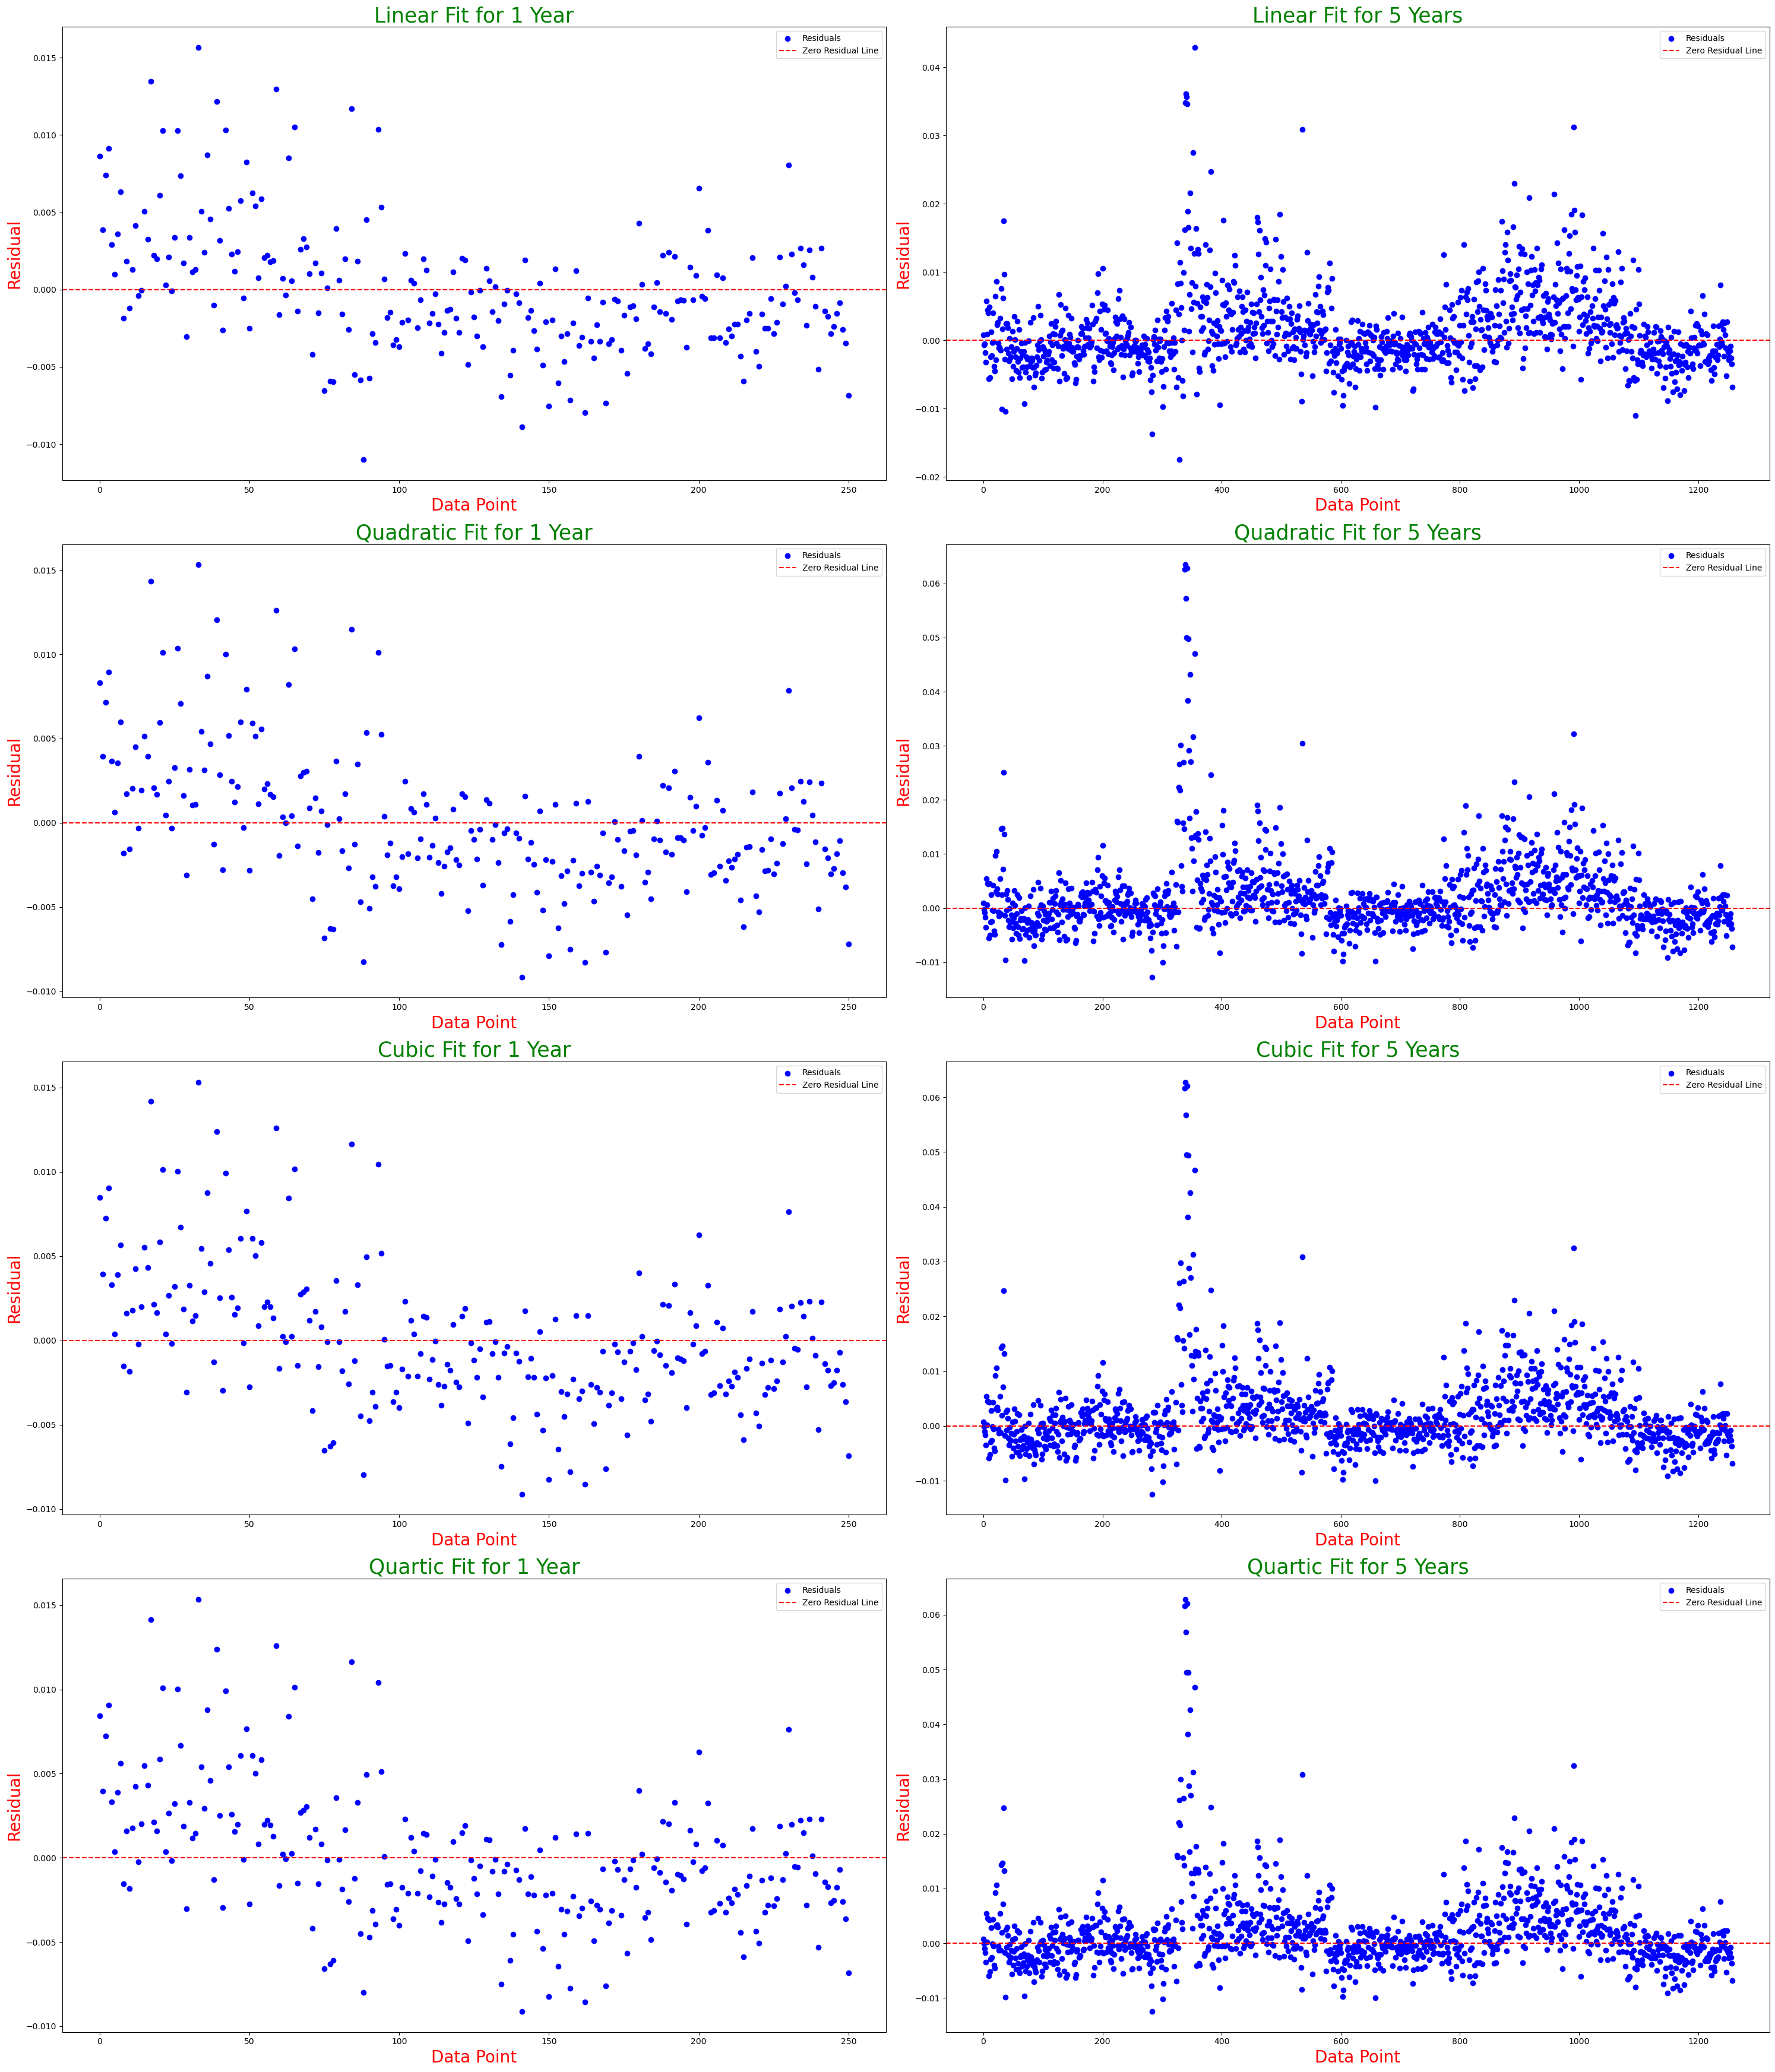

In [14]:
# Residual plots
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_linearfit.predicted_values(spy_1y, lin_a, lin_b)).residual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_linearfit.predicted_values(spy_5y, lin_a, lin_b)).residual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_quadraticfit.predicted_values(spy_1y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_quadraticfit.predicted_values(spy_5y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_cubicfit.predicted_values(spy_1y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_cubicfit.predicted_values(spy_5y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_1y.Volatility, predicted_values=spy_quarticfit.predicted_values(spy_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=spy_5y.Volatility, predicted_values=spy_quarticfit.predicted_values(spy_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


The distance from the line at 0 is how bad the prediction was for that value.

| Fit | Observation |
| :- | :-: |
| Linear | In the 1-year residual plot, we observe the presence of numerous residuals scattered in both directions around the zero residual line, suggesting some degree of heteroscedasticity in the 1-year data. In contrast, when examining the 5-year residual plot, we notice a significant increase in residuals primarily located above the zero residual line, indicating a more pronounced form of heteroscedasticity in the extended 5-year dataset, particularly in the positive direction from the predicted values. This suggests a higher level of variability in the residuals as we extend the time frame to 5 years.|
| Quadratic | The residual plots for both the 1-year and 5-year datasets exhibit similar trends as observed in the Linear Fit Equation analysis. In both cases, we note analogous patterns, which suggest consistent characteristics between the data points and the linear fit equations.|
| Cubic |  The residual plots for both the 1-year and 5-year datasets exhibit similar trends as observed in the Linear Fit Equation analysis. In both cases, we note analogous patterns, which suggest consistent characteristics between the data points and the linear fit equations. Transforming the data is the go-to approach to remove heteroskedasticity. The goal is to stabilize the variance and to bring the distribution closer to the Normal distribution. |
| Quartic | The residual plots for both the 1-year and 5-year datasets exhibit similar trends as observed in the Linear Fit Equation analysis. In both cases, we note analogous patterns, which suggest consistent characteristics between the data points and the linear fit equations. Transforming the data is the go-to approach to remove heteroskedasticity. The goal is to stabilize the variance and to bring the distribution closer to the Normal distribution.  |

In [15]:
# Create an empty DataFrame
fit_eval = pd.DataFrame(columns=['Fit Type', 'Symbol', 'Period', 'RMSE', 'R2'])

# Define the data for the new row
linear_1Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'SPY',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_linearfit.predicted_values(spy_1y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_linearfit.predicted_values(spy_1y, lin_a, lin_b)).calculate_r2()
}
# Define the data for the new row
linear_5Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'SPY',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_linearfit.predicted_values(spy_5y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_linearfit.predicted_values(spy_5y, lin_a, lin_b)).calculate_r2()
}

quad_1Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'SPY',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_quadraticfit.predicted_values(spy_1y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_quadraticfit.predicted_values(spy_1y, quad_a, quad_b, quad_c)).calculate_r2()
}
quad_5Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'SPY',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_quadraticfit.predicted_values(spy_5y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_quadraticfit.predicted_values(spy_5y, quad_a, quad_b, quad_c)).calculate_r2()
}

cub_1Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'SPY',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_cubicfit.predicted_values(spy_1y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_cubicfit.predicted_values(spy_1y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}
cub_5Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'SPY',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_cubicfit.predicted_values(spy_5y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_cubicfit.predicted_values(spy_5y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}

quar_1Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'SPY',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_quarticfit.predicted_values(spy_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_1y.Volatility,predicted_values=spy_quarticfit.predicted_values(spy_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}
quar_5Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'SPY',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_quarticfit.predicted_values(spy_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=spy_5y.Volatility,predicted_values=spy_quarticfit.predicted_values(spy_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}



# Add the new row to the DataFrame
fit_eval = fit_eval.append([linear_1Y,linear_5Y, quad_1Y, quad_5Y, cub_1Y, cub_5Y, quar_1Y, quar_5Y], ignore_index=True)

fit_eval


Fit Type Symbol Period      RMSE        R2
0     Linear    SPY     1Y  0.004165  0.403586
1     Linear    SPY     5Y  0.005854  0.656955
2  Quadratic    SPY     1Y  0.004136  0.411852
3  Quadratic    SPY     5Y  0.007367  0.456860
4      Cubic    SPY     1Y  0.004130  0.413458
5      Cubic    SPY     5Y  0.007323  0.463304
6    Quartic    SPY     1Y  0.004130  0.413485
7    Quartic    SPY     5Y  0.007326  0.462825

|FIT|OBSERVATION|BETTER OR WORSE FIT|
|:-|:-:|-:|
|Linear|In the 1-year period, the Linear model performs decently with a moderate RMSE and R2, indicating a fair fit. In the 5-year period, the Linear model shows a notably improved R2, suggesting a better fit for explaining variance, but with slightly larger prediction errors.|Better Fit|
|Quadratic|Over one year, the Quadratic model does a tad better than the Linear one, with slightly smaller prediction errors and a somewhat higher ability to explain what's going on. But over five years, Quadratic model is doing a better job at making sense of things.|Better Fit|
|Cubic|In the 1-year period, the Cubic model performs similarly to the Quadratic model, with a slightly lower RMSE and a comparable R2. In the 5-year period, the Cubic model has a higher R2, indicating a better fit in explaining variance, though it comes with slightly larger prediction errors.|Better Fit|
|Quartic|The Quartic model exhibits similar performance to the Cubic model for both 1-year and 5-year periods, with modest RMSE and R2 values.|Better Fit|

<h3 style="color:#1616a7"><b>2. Continue Research with Other ETFs</b></h3>

In [16]:
# Checking the plot of TQQQ
tqqq = HandleDataFrame('TQQQ')

In [17]:
# Load TQQQ 1 year data
tqqq_1y = tqqq.load_data("1Y")
tqqq_1y = tqqq.calculate_volatility_volume(tqqq_1y)
tqqq_1y.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2022-11-04  18.129999  18.350000  16.850000  17.950001  17.635723  382370200   
2022-11-07  18.160000  18.639999  17.709999  18.520000  18.195744  200943400   
2022-11-08  18.850000  19.620001  18.090000  18.920000  18.588739  296056300   
2022-11-09  18.530001  18.700001  17.530001  17.600000  17.291851  215569100   
2022-11-10  20.150000  21.540001  19.700001  21.450001  21.074446  328442400   

            Volatility  Volume_delta  Volatility_delta  
Date                                                    
2022-11-04    0.083565  -181426800.0         -0.033349  
2022-11-07    0.050216  -181426800.0         -0.033349  
2022-11-08    0.080867    95112900.0          0.030651  
2022-11-09    0.066477   -80487200.0         -0.014390  
2022-11-10    0.085781   112873300.0          0.019304

In [18]:
# Load TQQQ 5 year data
tqqq_5y = tqqq.load_data("5Y")
tqqq_5y = tqqq.calculate_volatility_volume(tqqq_5y)
tqqq_5y.head()

[*********************100%%**********************]  1 of 1 completed


Open     High      Low    Close  Adj Close    Volume  \
Date                                                                  
2018-11-05  13.0200  13.0350  12.4400  12.8850  12.633272  51300400   
2018-11-06  12.8525  13.3825  12.8175  13.1575  12.900448  55730800   
2018-11-07  13.6275  14.3900  13.5425  14.3675  14.086809  69276000   
2018-11-08  14.1975  14.3300  13.9150  14.1225  13.846596  58762400   
2018-11-09  13.7300  13.8200  13.0725  13.4050  13.143113  68369600   

            Volatility  Volume_delta  Volatility_delta  
Date                                                    
2018-11-05    0.046178     4430400.0         -0.003236  
2018-11-06    0.042941     4430400.0         -0.003236  
2018-11-07    0.058987    13545200.0          0.016046  
2018-11-08    0.029386   -10513600.0         -0.029602  
2018-11-09    0.055763     9607200.0          0.026377

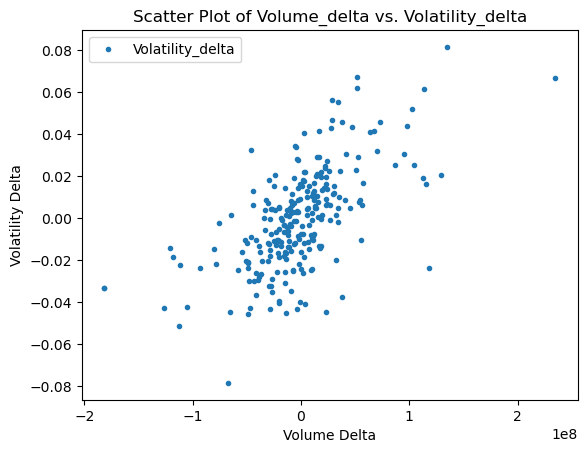

In [19]:
# Plot Volume_delta and Volatility_delta for 1Y
tqqq.plot_delta(tqqq_1y)

Our Linear Fit Equation is y = 2.407129942583719e-10 * x + 0.013807866343370567 

Our Quadratic Fit Equation is y = -2.1793686856723213e-19 * x**2 + 3.197369154598449e-10 * x + 0.0077422715968460416 

Our Cubic Fit Equation is y = -1.3918602842397858e-22 * x**3 + -2.1739151634934925e-19 * x**2 + :3.193143531522822e-10 * x + 0.007743614422889732 

Our Quartic Fit Equation is y = -1.2262885476264595e-22 * x**4 + -1.3160951280059354e-22 * x**3 + :-2.1468360880310123e-19 * x**2 + 3.18905777713789e-10 * x + 0.0076841778035065785 



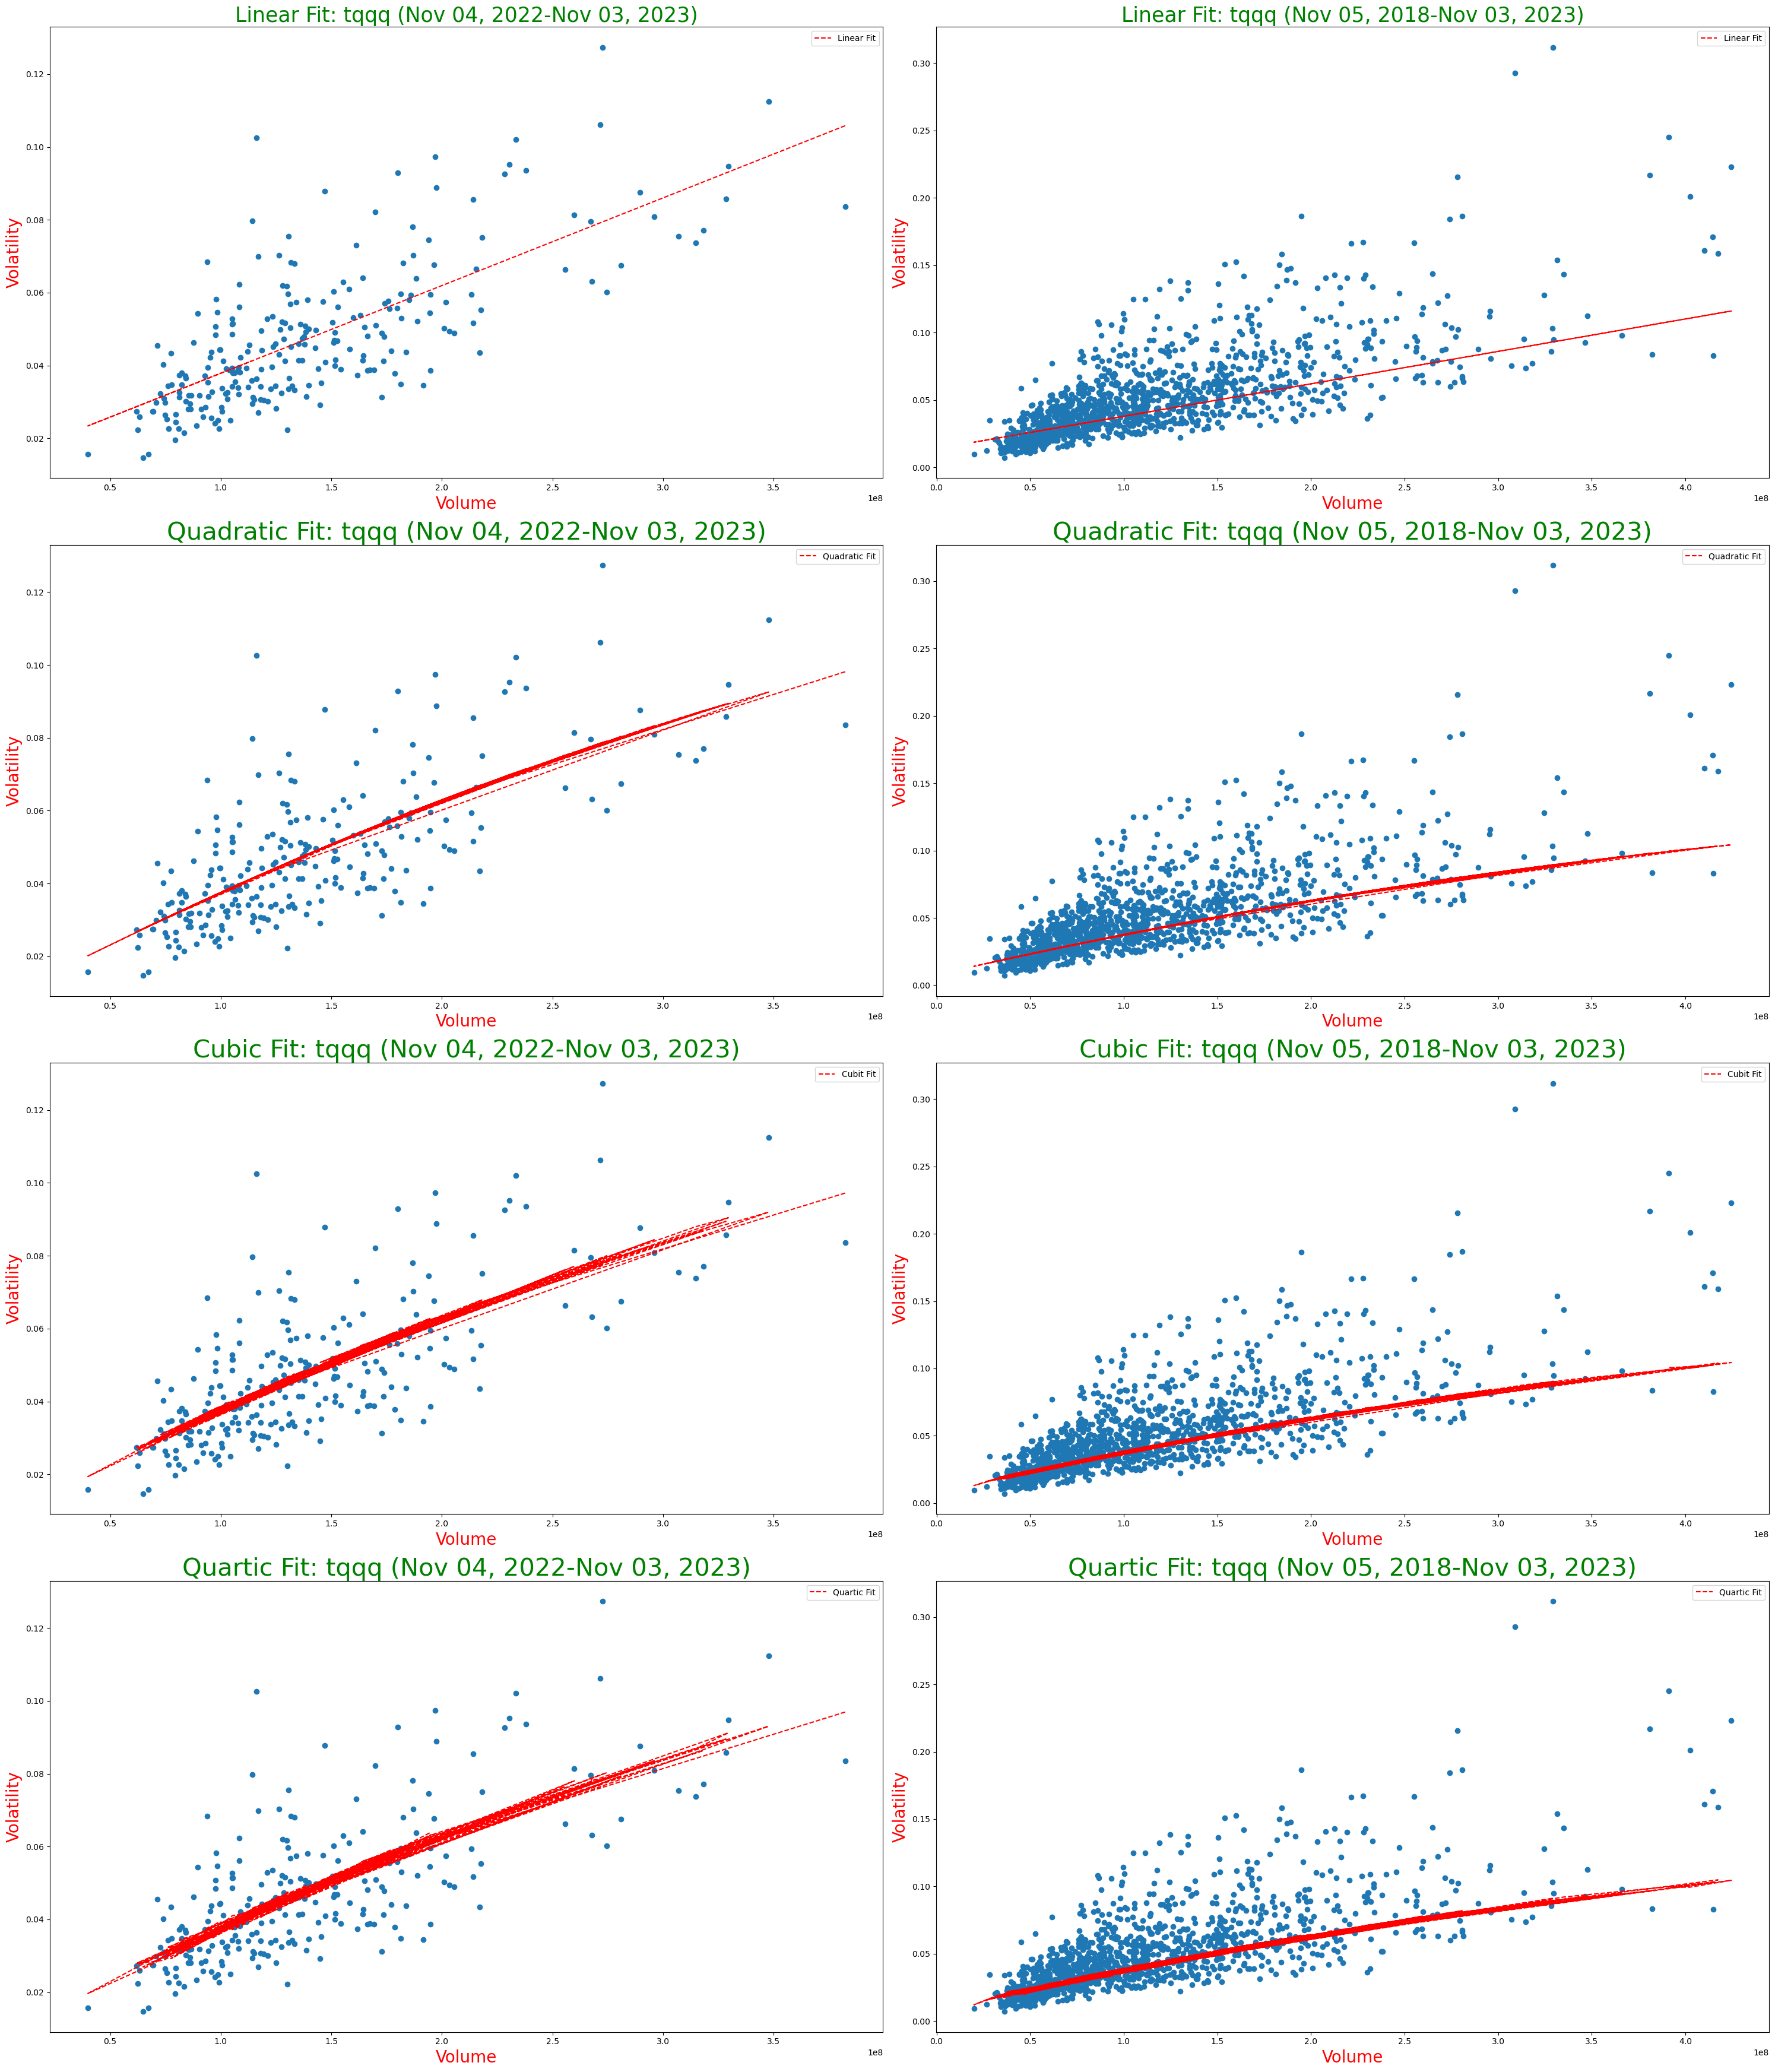

In [20]:
# tqqq 1Y Linear equation
tqqq_linearfit = Linear(tqqq_1y,'tqqq')
lin_a, lin_b = tqqq_linearfit.linear_fit()
print(f"Our Linear Fit Equation is y = {lin_a} * x + {lin_b} \n")

# tqqq 1Y Quadratic equation
tqqq_quadraticfit = Quadratic(tqqq_1y,'tqqq')
quad_a, quad_b, quad_c = tqqq_quadraticfit.quadratic_fit()
# Print the equation
print(f"Our Quadratic Fit Equation is y = {quad_a} * x**2 + {quad_b} * x + {quad_c} \n")

# tqqq 1Y Cubic equation
tqqq_cubicfit = Cubic(tqqq_1y,'tqqq')
cub_a, cub_b, cub_c, cub_d = tqqq_cubicfit.cubic_fit()
print(f"Our Cubic Fit Equation is y = {cub_a} * x**3 + {cub_b} * x**2 + :{cub_c} * x + {cub_d} \n")

# tqqq 1Y Quartic equation
tqqq_quarticfit = Quartic(tqqq_1y,'tqqq')
quar_a, quar_b, quar_c, quar_d, quar_e = tqqq_quarticfit.quartic_fit()
print(f"Our Quartic Fit Equation is y = {quar_a} * x**4 + {quar_b} * x**3 + :{quar_c} * x**2 + {quar_d} * x + {quar_e} \n")


# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Plot Linear Fit
plt.subplot(421)
tqqq_linearfit.plot_linear(tqqq_1y, lin_a, lin_b)

plt.subplot(422)
tqqq_linearfit.plot_linear(tqqq_5y, lin_a, lin_b)


# Plot Quadratic fit
plt.subplot(423)
tqqq_quadraticfit.plot_quadratic(tqqq_1y, quad_a, quad_b, quad_c)

plt.subplot(424)
tqqq_quadraticfit.plot_quadratic(tqqq_5y, quad_a, quad_b, quad_c)


# Plot Cubic fit
plt.subplot(425)
tqqq_cubicfit.plot_cubic(tqqq_1y, cub_a, cub_b, cub_c, cub_d)

plt.subplot(426)
tqqq_cubicfit.plot_cubic(tqqq_5y, cub_a, cub_b, cub_c, cub_d)


# Plot Quartic fit
plt.subplot(427)
tqqq_quarticfit.plot_quartic(tqqq_1y, quar_a, quar_b, quar_c, quar_d, quar_e)

plt.subplot(428)
tqqq_quarticfit.plot_quartic(tqqq_5y, quar_a, quar_b, quar_c, quar_d, quar_e)

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

| FIT | 1 YEAR | 5 YEARS | FINAL THOUGHTS |
| :- | :-: | :-: | :-: |
| Linear |We can see that the data points are moderately scattered around the linear fit line. Although there is some variability, they typically stay close to this line.|A distinct shift in the pattern can be seen. In this case, the majority of data points are positioned above the linear fit line, indicating a poorer fit for the 5-year data. The clustering of data points above the line suggests an inadequate distribution for our linear fit.|Our Linear Fit does not look to be doing well when we tested it on the 5 Years data.|
| Quadratic |We can see that the data points are moderately scattered around the Quadratic fit line. Although there is some variability, they typically stay close to this line.| A distinct shift in the pattern can be seen. In this case, the majority of data points are positioned above the linear fit line, indicating a poorer fit for the 5-year data. The clustering of data points above the line suggests an inadequate distribution for our quadratic fit.|Quadratic Fit is not doing as well on 5 Years data.|
| Cubic |Cubic Fit shows similar pattern as quadratic fit equation.|Cubic Fit shows similar pattern as quadratic fit equation.| Cubic Fit is also not doing as well either. |
| Quartic |Quartic Fit shows similar pattern as quadratic fit equation.|Quartic Fit shows similar pattern as quadratic fit equation. |Quartic Fit is not doing as well.  |

Let's now check the Residual and Predicted vs Actual plots to analyse further.

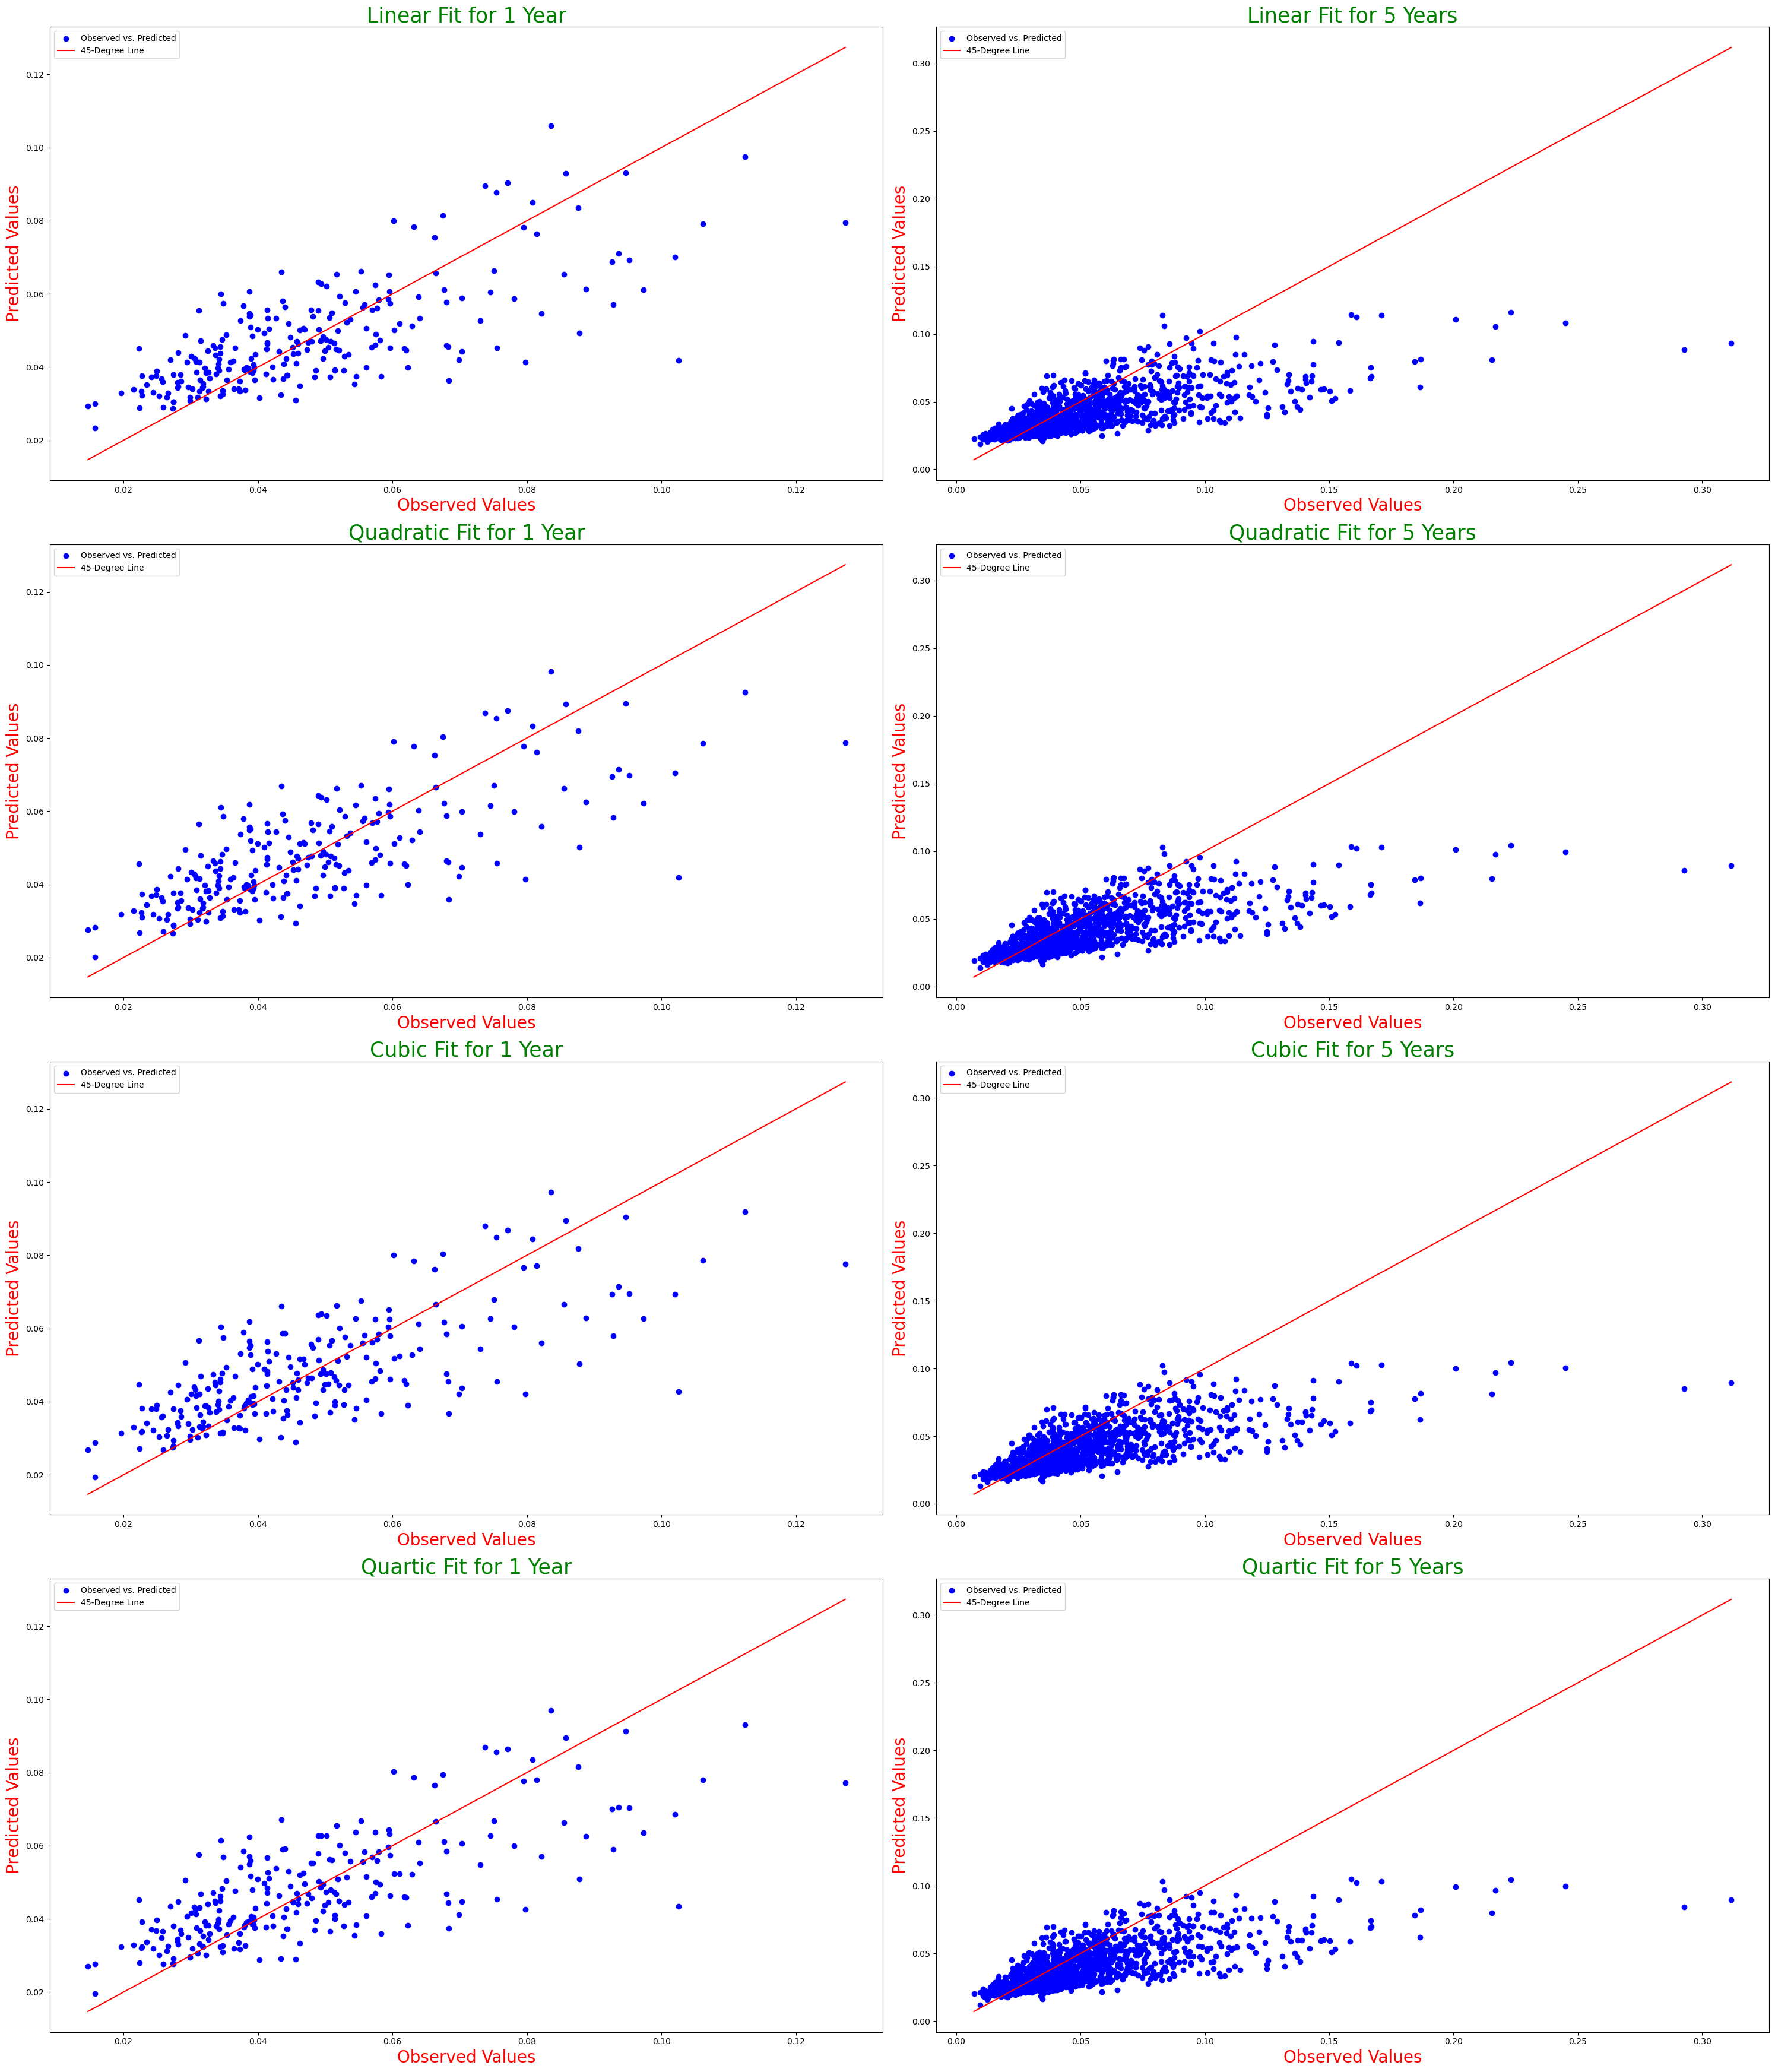

In [21]:
# Predicted vs Actual plot
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_linearfit.predicted_values(tqqq_1y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_linearfit.predicted_values(tqqq_5y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_quadraticfit.predicted_values(tqqq_1y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_quadraticfit.predicted_values(tqqq_5y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_cubicfit.predicted_values(tqqq_1y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_cubicfit.predicted_values(tqqq_5y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_quarticfit.predicted_values(tqqq_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_quarticfit.predicted_values(tqqq_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


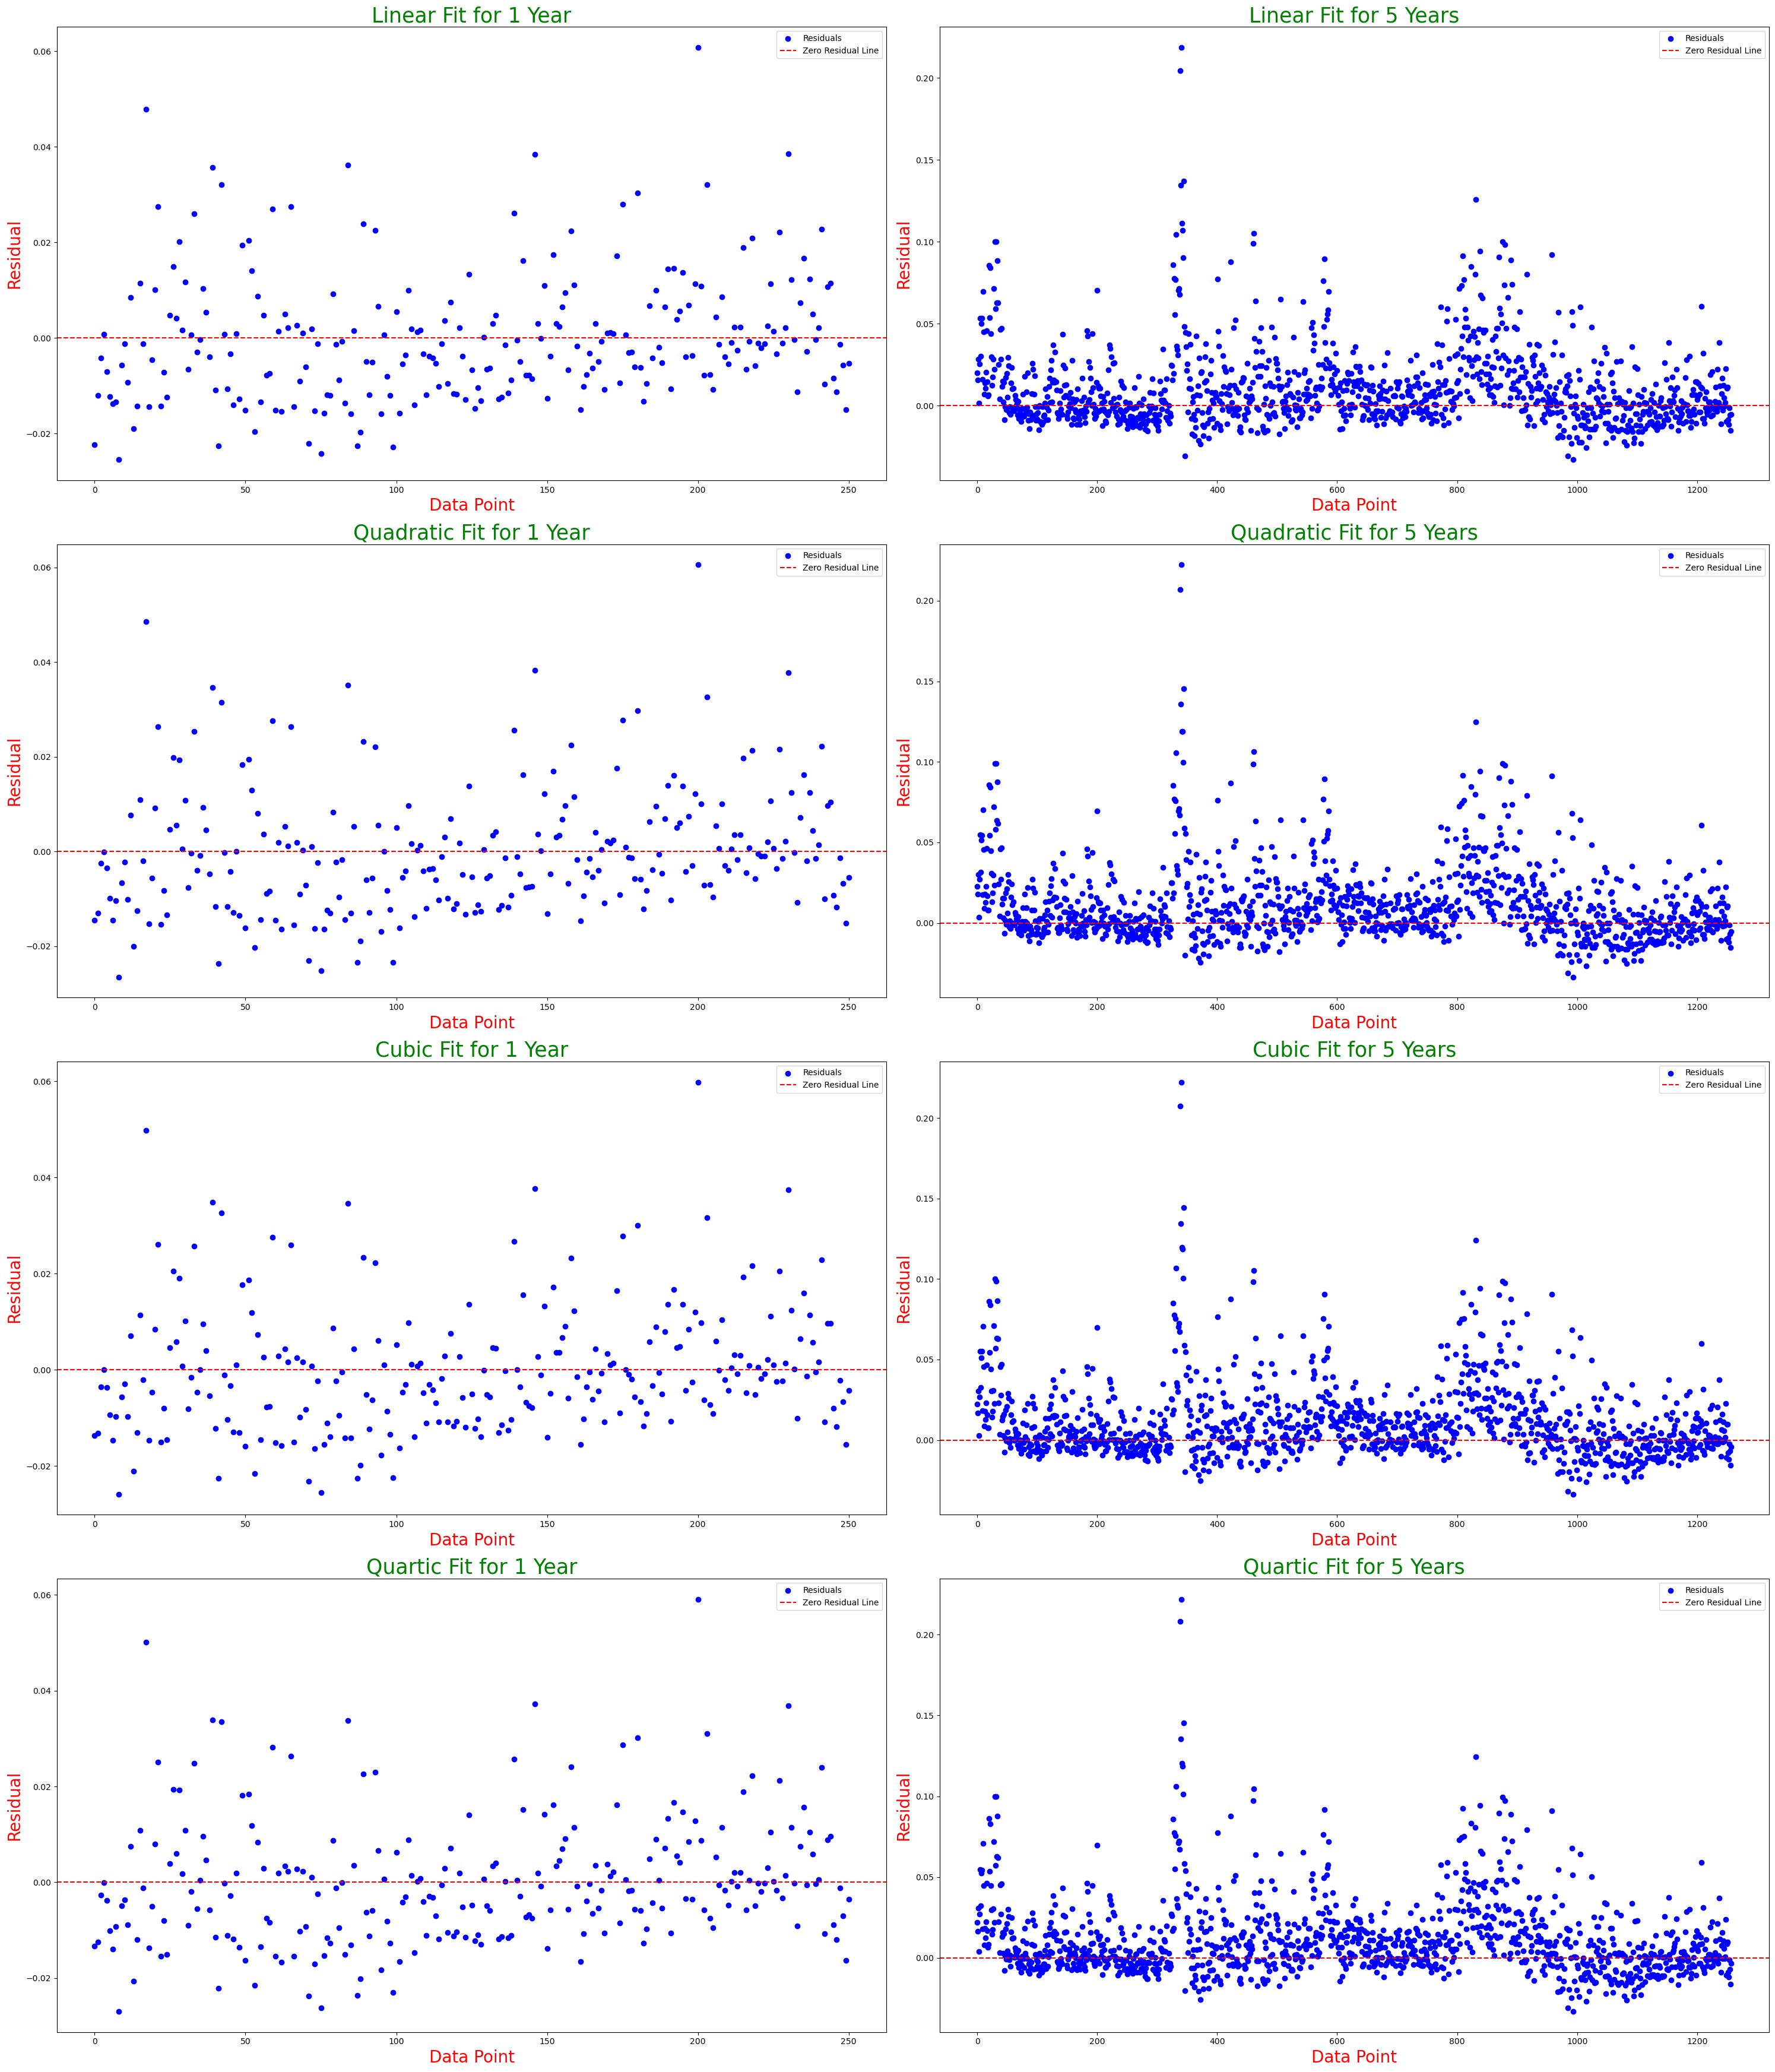

In [22]:
# Residual plots
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_linearfit.predicted_values(tqqq_1y, lin_a, lin_b)).residual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_linearfit.predicted_values(tqqq_5y, lin_a, lin_b)).residual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_quadraticfit.predicted_values(tqqq_1y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_quadraticfit.predicted_values(tqqq_5y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_cubicfit.predicted_values(tqqq_1y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_cubicfit.predicted_values(tqqq_5y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_1y.Volatility, predicted_values=tqqq_quarticfit.predicted_values(tqqq_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=tqqq_5y.Volatility, predicted_values=tqqq_quarticfit.predicted_values(tqqq_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


The distance from the line at 0 is how bad the prediction was for that value.

| Fit | Observation |
| :- | :-: |
| Linear | In the 1-year residual plot, we observe the presence of numerous residuals scattered in both directions around the zero residual line, suggesting some degree of heteroscedasticity in the 1-year data. In contrast, when examining the 5-year residual plot, we notice a significant increase in residuals primarily located above the zero residual line, indicating a more pronounced form of heteroscedasticity in the extended 5-year dataset, particularly in the positive direction from the predicted values. This suggests a higher level of variability in the residuals as we extend the time frame to 5 years. The most frequently successful solution is to transform a variable. This could also mean that a variable is missing.|
| Quadratic | The residual plots for both the 1-year and 5-year datasets exhibit similar trends as observed in the Linear Fit Equation analysis. In both cases, we note analogous patterns, which suggest consistent characteristics between the data points and the linear fit equations. The most frequently successful solution is to transform a variable. This could also mean that a variable is missing.|
| Cubic |  The residual plots for both the 1-year and 5-year datasets exhibit similar trends as observed in the Linear Fit Equation analysis. In both cases, we note analogous patterns, which suggest consistent characteristics between the data points and the linear fit equations. Transforming the data is the go-to approach to remove heteroskedasticity. The goal is to stabilize the variance and to bring the distribution closer to the Normal distribution. The most frequently successful solution is to transform a variable. This could also mean that a variable is missing.|
| Quartic | The residual plots for both the 1-year and 5-year datasets exhibit similar trends as observed in the Linear Fit Equation analysis. In both cases, we note analogous patterns, which suggest consistent characteristics between the data points and the linear fit equations. Transforming the data is the go-to approach to remove heteroskedasticity. The goal is to stabilize the variance and to bring the distribution closer to the Normal distribution. The most frequently successful solution is to transform a variable. This could also mean that a variable is missing. |

In [23]:
# Create an empty DataFrame
fit_eval = pd.DataFrame(columns=['Fit Type', 'Symbol', 'Period', 'RMSE', 'R2'])

# Define the data for the new row
linear_1Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'TQQQ',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_linearfit.predicted_values(tqqq_1y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_linearfit.predicted_values(tqqq_1y, lin_a, lin_b)).calculate_r2()
}
# Define the data for the new row
linear_5Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'TQQQ',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_linearfit.predicted_values(tqqq_5y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_linearfit.predicted_values(tqqq_5y, lin_a, lin_b)).calculate_r2()
}

quad_1Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'TQQQ',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_quadraticfit.predicted_values(tqqq_1y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_quadraticfit.predicted_values(tqqq_1y, quad_a, quad_b, quad_c)).calculate_r2()
}
quad_5Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'TQQQ',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_quadraticfit.predicted_values(tqqq_5y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_quadraticfit.predicted_values(tqqq_5y, quad_a, quad_b, quad_c)).calculate_r2()
}

cub_1Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'TQQQ',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_cubicfit.predicted_values(tqqq_1y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_cubicfit.predicted_values(tqqq_1y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}
cub_5Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'TQQQ',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_cubicfit.predicted_values(tqqq_5y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_cubicfit.predicted_values(tqqq_5y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}

quar_1Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'TQQQ',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_quarticfit.predicted_values(tqqq_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_1y.Volatility,predicted_values=tqqq_quarticfit.predicted_values(tqqq_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}
quar_5Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'TQQQ',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_quarticfit.predicted_values(tqqq_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=tqqq_5y.Volatility,predicted_values=tqqq_quarticfit.predicted_values(tqqq_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}



# Add the new row to the DataFrame
fit_eval = fit_eval.append([linear_1Y,linear_5Y, quad_1Y, quad_5Y, cub_1Y, cub_5Y, quar_1Y, quar_5Y], ignore_index=True)

fit_eval


Fit Type Symbol Period      RMSE        R2
0     Linear   TQQQ     1Y  0.013315  0.529734
1     Linear   TQQQ     5Y  0.026217  0.363964
2  Quadratic   TQQQ     1Y  0.013268  0.533079
3  Quadratic   TQQQ     5Y  0.026417  0.354249
4      Cubic   TQQQ     1Y  0.013249  0.534427
5      Cubic   TQQQ     5Y  0.026434  0.353388
6    Quartic   TQQQ     1Y  0.013232  0.535634
7    Quartic   TQQQ     5Y  0.026473  0.351478

|FIT|OBSERVATION|BETTER OR WORSE FIT|
|:-|:-:|-:|
|Linear| RMSE increases and R2 decreases, suggesting larger prediction errors and lower explanatory power. The lack of a consistent increase in data points over the 5-year period could be a contributing factor to the model's suboptimal performance when dealing with the longer time frame. The model may not have enough predictive power to capture the underlying patterns in the data. It may provide good fits for shorter periods but struggle to make accurate long-term predictions.|Worse Fit|
|Quadratic|RMSE increases and R2 decreases. The lack of a consistent increase in data points over the 5-year period could be a contributing factor to the model's suboptimal performance when dealing with the longer time frame. The model may not have enough predictive power to capture the underlying patterns in the data. It may provide good fits for shorter periods but struggle to make accurate long-term predictions.|Worse Fit|
|Cubic|RMSE increases and R2 decreases. The lack of a consistent increase in data points over the 5-year period could be a contributing factor to the model's suboptimal performance when dealing with the longer time frame. The model may not have enough predictive power to capture the underlying patterns in the data. It may provide good fits for shorter periods but struggle to make accurate long-term predictions.|Worse Fit|
|Quartic|RMSE increases and R2 decreases. The lack of a consistent increase in data points over the 5-year period could be a contributing factor to the model's suboptimal performance when dealing with the longer time frame. The model may not have enough predictive power to capture the underlying patterns in the data. It may provide good fits for shorter periods but struggle to make accurate long-term predictions.|Worse Fit|

<h3 style="color:#1616a7"><b>3. Extend Research on Other Stocks</b></h3>

### AMZN

In [24]:
# Checking the plot of AAPL
amzn = HandleDataFrame('AMZN')

In [25]:
# Load AMZN 1 year data
amzn_1y = amzn.load_data("1Y")
amzn_1y = amzn.calculate_volatility_volume(amzn_1y)
amzn_1y.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2022-11-04  91.489998  92.440002  88.040001  90.980003  90.980003  129101300   
2022-11-07  91.949997  92.099998  89.040001  90.529999  90.529999   77495700   
2022-11-08  90.790001  91.720001  88.230003  89.980003  89.980003   88703400   
2022-11-09  89.470001  89.480003  85.870003  86.139999  86.139999   90796200   
2022-11-10  92.940002  98.690002  91.650002  96.629997  96.629997  173414900   

            Volatility  Volume_delta  Volatility_delta  
Date                                                    
2022-11-04    0.048362   -51605600.0         -0.014561  
2022-11-07    0.033801   -51605600.0         -0.014561  
2022-11-08    0.038786    11207700.0          0.004985  
2022-11-09    0.041909     2092800.0          0.003122  
2022-11-10    0.072855    82618700.0          0.030947

In [26]:
# Load AMZN 5 year data
amzn_5y = amzn.load_data("5Y")
amzn_5y = amzn.calculate_volatility_volume(amzn_5y)
amzn_5y.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-11-05  82.878502  82.904503  79.818001  81.389999  81.389999  112494000   
2018-11-06  80.917503  83.250000  80.727501  82.140503  82.140503   85148000   
2018-11-07  83.650002  87.961502  83.204002  87.774498  87.774498  163844000   
2018-11-08  87.750000  89.199997  86.255501  87.745499  87.745499  130698000   
2018-11-09  86.625000  87.195999  85.093498  85.621498  85.621498  118044000   

            Volatility  Volume_delta  Volatility_delta  
Date                                                    
2018-11-05    0.037922   -27346000.0         -0.007213  
2018-11-06    0.030710   -27346000.0         -0.007213  
2018-11-07    0.054201    78696000.0          0.023492  
2018-11-08    0.033557   -33146000.0         -0.020644  
2018-11-09    0.024556   -12654000.0         -0.009001

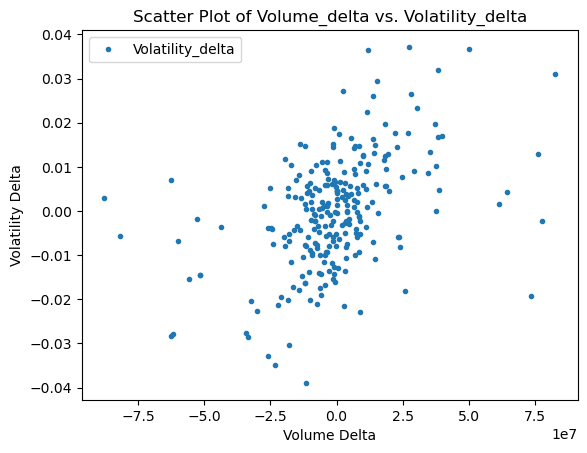

In [27]:
# Plot Volume_delta and Volatility_delta for 1Y
amzn.plot_delta(amzn_1y)

Our Linear Fit Equation is y = 2.9339231089717535e-10 * x + 0.009101024051116865 

Our Quadratic Fit Equation is y = -1.6977099767488739e-18 * x**2 + 5.8493203801361e-10 * x + -0.0016845622725856785 

Our Cubic Fit Equation is y = 2.106013056426926e-23 * x**3 + -1.7074432451587428e-18 * x**2 + :5.866748473176422e-10 * x + -0.0017469973849857004 

Our Quartic Fit Equation is y = -1.1825815956596028e-22 * x**4 + 2.361565423270458e-23 * x**3 + :-1.6635883777339038e-18 * x**2 + 5.797065283840125e-10 * x + -0.0014971037505769138 



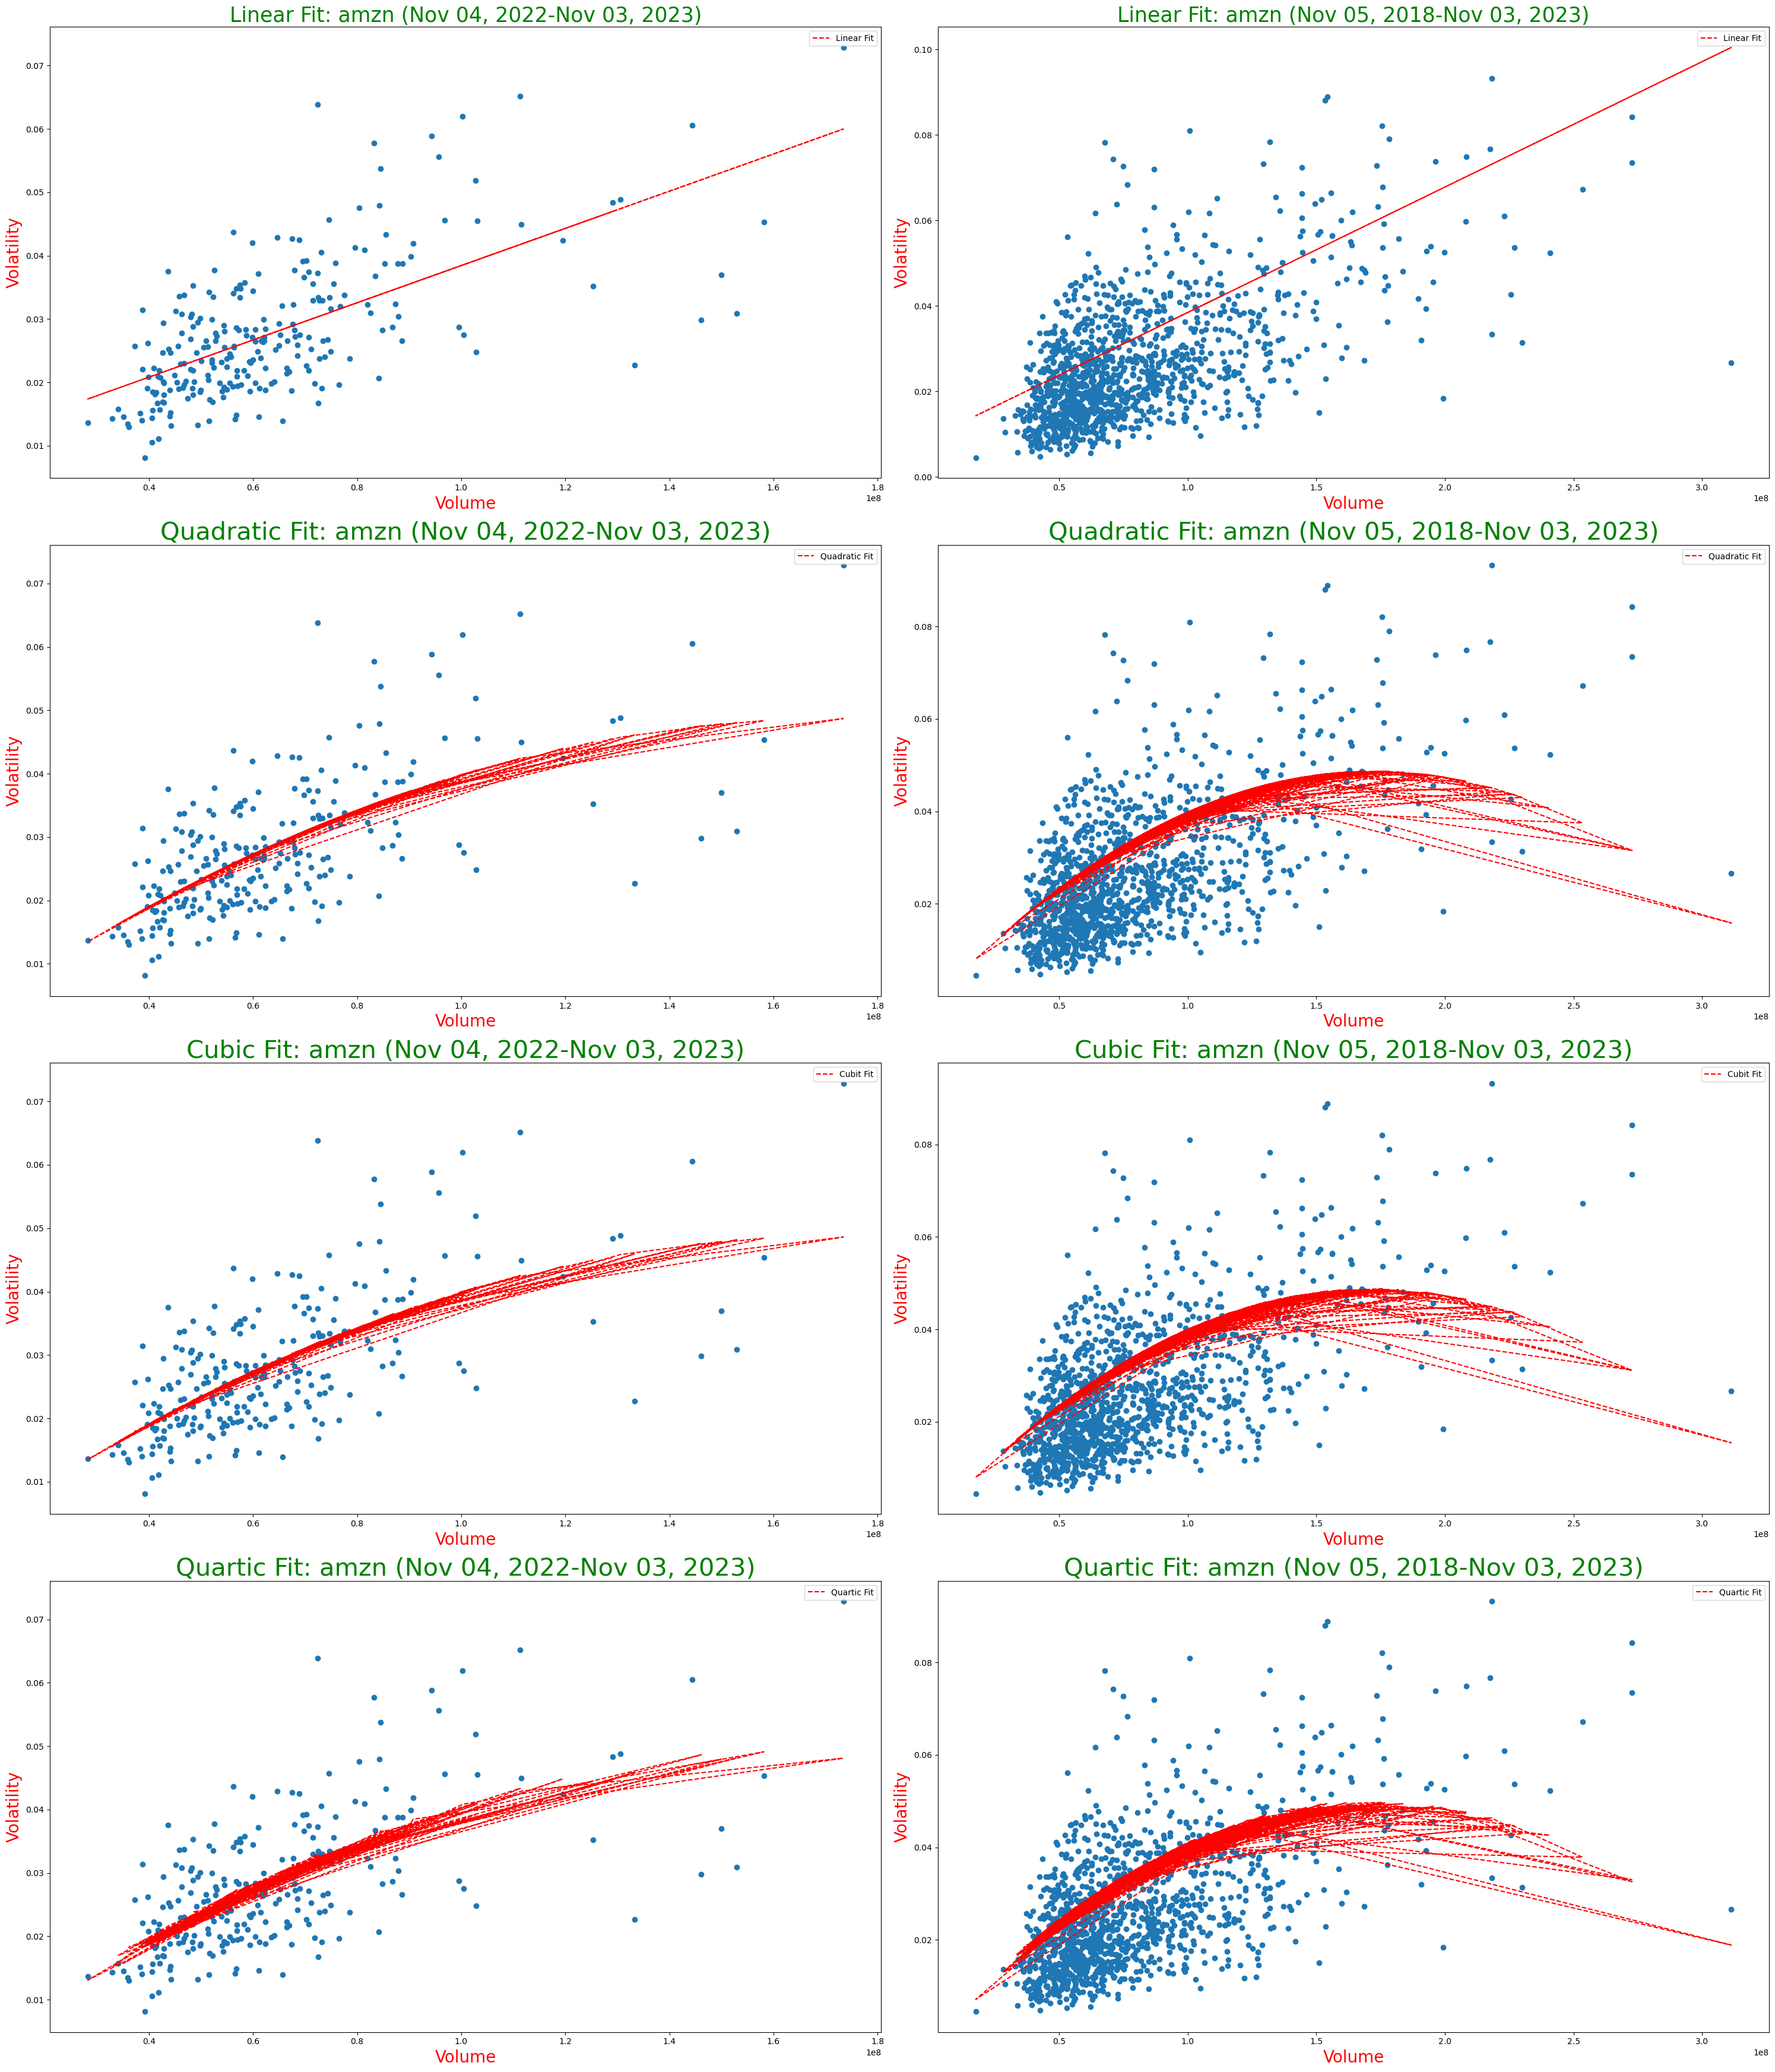

In [28]:
# amzn 1Y Linear equation
amzn_linearfit = Linear(amzn_1y,'amzn')
lin_a, lin_b = amzn_linearfit.linear_fit()
print(f"Our Linear Fit Equation is y = {lin_a} * x + {lin_b} \n")

# amzn 1Y Quadratic equation
amzn_quadraticfit = Quadratic(amzn_1y,'amzn')
quad_a, quad_b, quad_c = amzn_quadraticfit.quadratic_fit()
# Print the equation
print(f"Our Quadratic Fit Equation is y = {quad_a} * x**2 + {quad_b} * x + {quad_c} \n")

# amzn 1Y Cubic equation
amzn_cubicfit = Cubic(amzn_1y,'amzn')
cub_a, cub_b, cub_c, cub_d = amzn_cubicfit.cubic_fit()
print(f"Our Cubic Fit Equation is y = {cub_a} * x**3 + {cub_b} * x**2 + :{cub_c} * x + {cub_d} \n")

# amzn 1Y Quartic equation
amzn_quarticfit = Quartic(amzn_1y,'amzn')
quar_a, quar_b, quar_c, quar_d, quar_e = amzn_quarticfit.quartic_fit()
print(f"Our Quartic Fit Equation is y = {quar_a} * x**4 + {quar_b} * x**3 + :{quar_c} * x**2 + {quar_d} * x + {quar_e} \n")


# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Plot Linear Fit
plt.subplot(421)
amzn_linearfit.plot_linear(amzn_1y, lin_a, lin_b)

plt.subplot(422)
amzn_linearfit.plot_linear(amzn_5y, lin_a, lin_b)


# Plot Quadratic fit
plt.subplot(423)
amzn_quadraticfit.plot_quadratic(amzn_1y, quad_a, quad_b, quad_c)

plt.subplot(424)
amzn_quadraticfit.plot_quadratic(amzn_5y, quad_a, quad_b, quad_c)


# Plot Cubic fit
plt.subplot(425)
amzn_cubicfit.plot_cubic(amzn_1y, cub_a, cub_b, cub_c, cub_d)

plt.subplot(426)
amzn_cubicfit.plot_cubic(amzn_5y, cub_a, cub_b, cub_c, cub_d)


# Plot Quartic fit
plt.subplot(427)
amzn_quarticfit.plot_quartic(amzn_1y, quar_a, quar_b, quar_c, quar_d, quar_e)

plt.subplot(428)
amzn_quarticfit.plot_quartic(amzn_5y, quar_a, quar_b, quar_c, quar_d, quar_e)

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

| FIT | 1 YEAR | 5 YEARS | FINAL THOUGHTS |
| :- | :-: | :-: | :-: |
| Linear |We can see that the data points are highly scattered around the linear fit line. |Looking at the 5-year data, it's evident that the data points are widely dispersed across the graph, and there is a notable presence of outlier points. This situation can pose challenges when working with our models unless we implement data transformation or scaling to improve the model's fit.|Our Linear Fit does not look to be doing well when we tested it on the 5 Years data.|
| Quadratic |We can see that the data points are highly scattered around the quadratic fit line. | Looking at the 5-year data, it's evident that the data points are widely dispersed across the graph, and there is a notable presence of outlier points. This situation can pose challenges when working with our models unless we implement data transformation or scaling to improve the model's fit.|Quadratic Fit is not doing as well on 5 Years data.|
| Cubic |Cubic Fit shows similar pattern as quadratic fit equation.|Cubic Fit shows similar pattern as quadratic fit equation.| Cubic Fit is also not doing as well either. |
| Quartic |Quartic Fit shows similar pattern as quadratic fit equation.|Quartic Fit shows similar pattern as quadratic fit equation. |Quartic Fit is not doing as well.  |

Let's now check the Residual and Predicted vs Actual plots to analyse further.

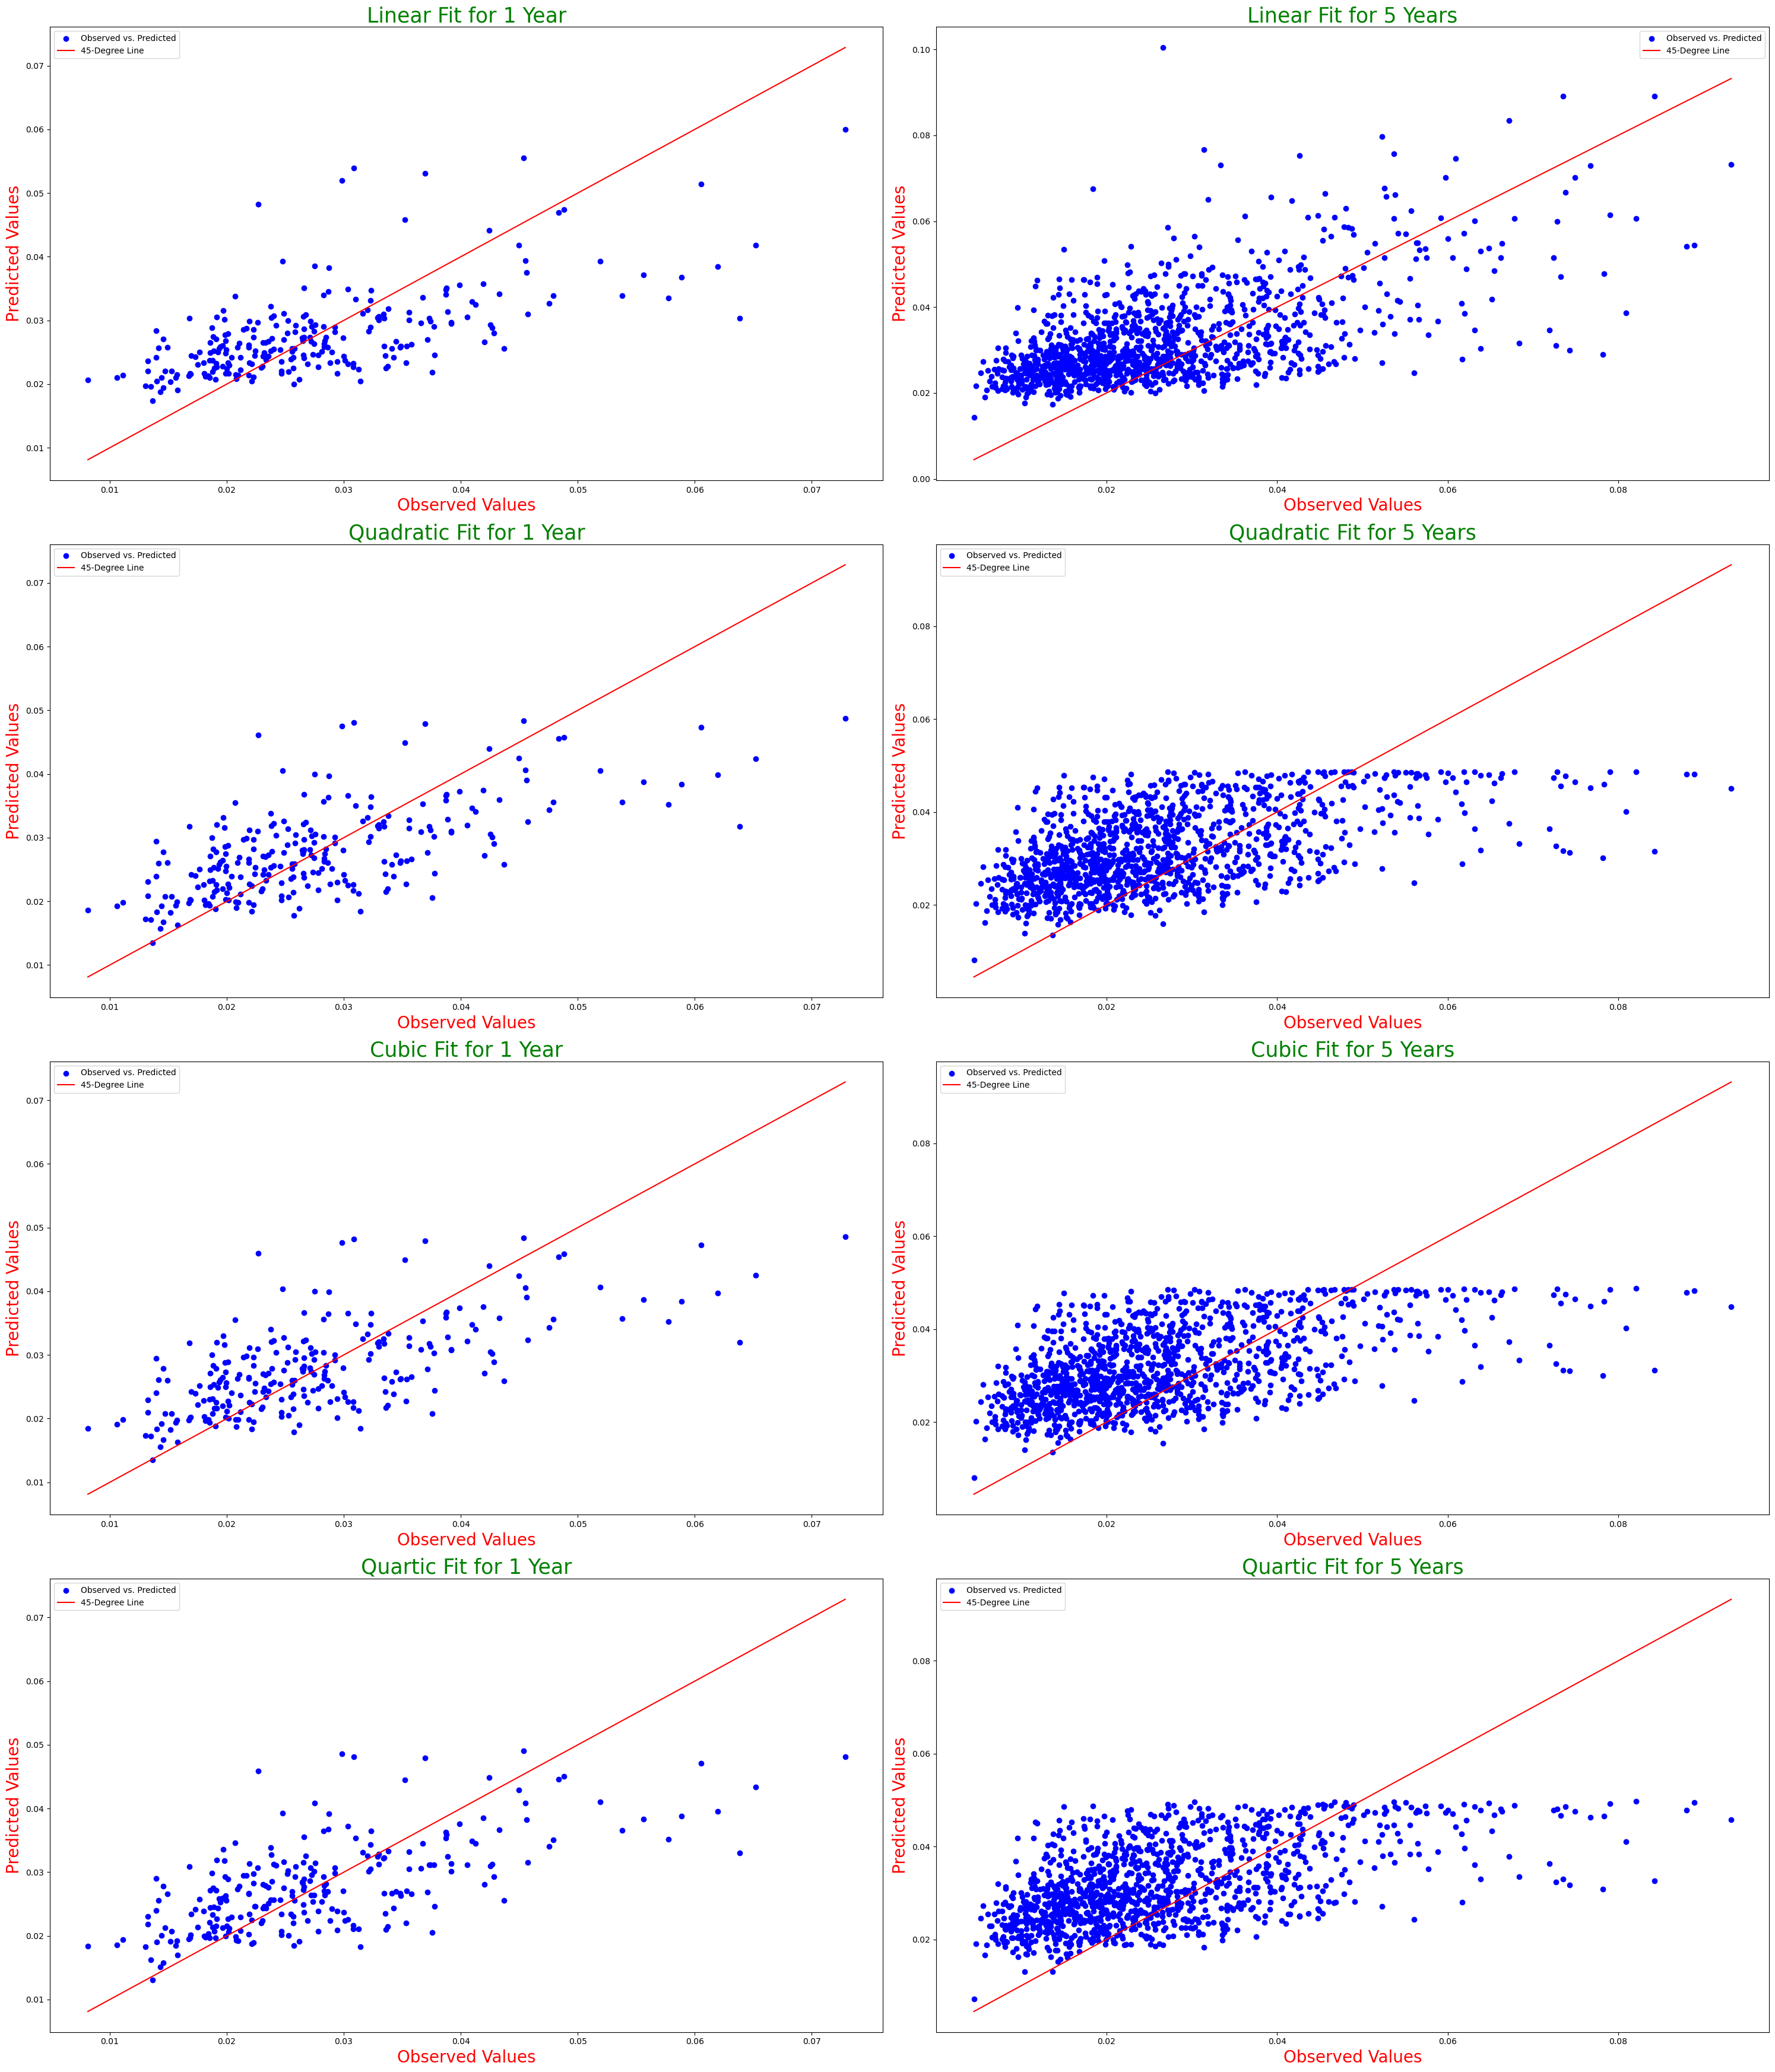

In [29]:
# Predicted vs Actual plot
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_linearfit.predicted_values(amzn_1y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_linearfit.predicted_values(amzn_5y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_quadraticfit.predicted_values(amzn_1y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_quadraticfit.predicted_values(amzn_5y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_cubicfit.predicted_values(amzn_1y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_cubicfit.predicted_values(amzn_5y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_quarticfit.predicted_values(amzn_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_quarticfit.predicted_values(amzn_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


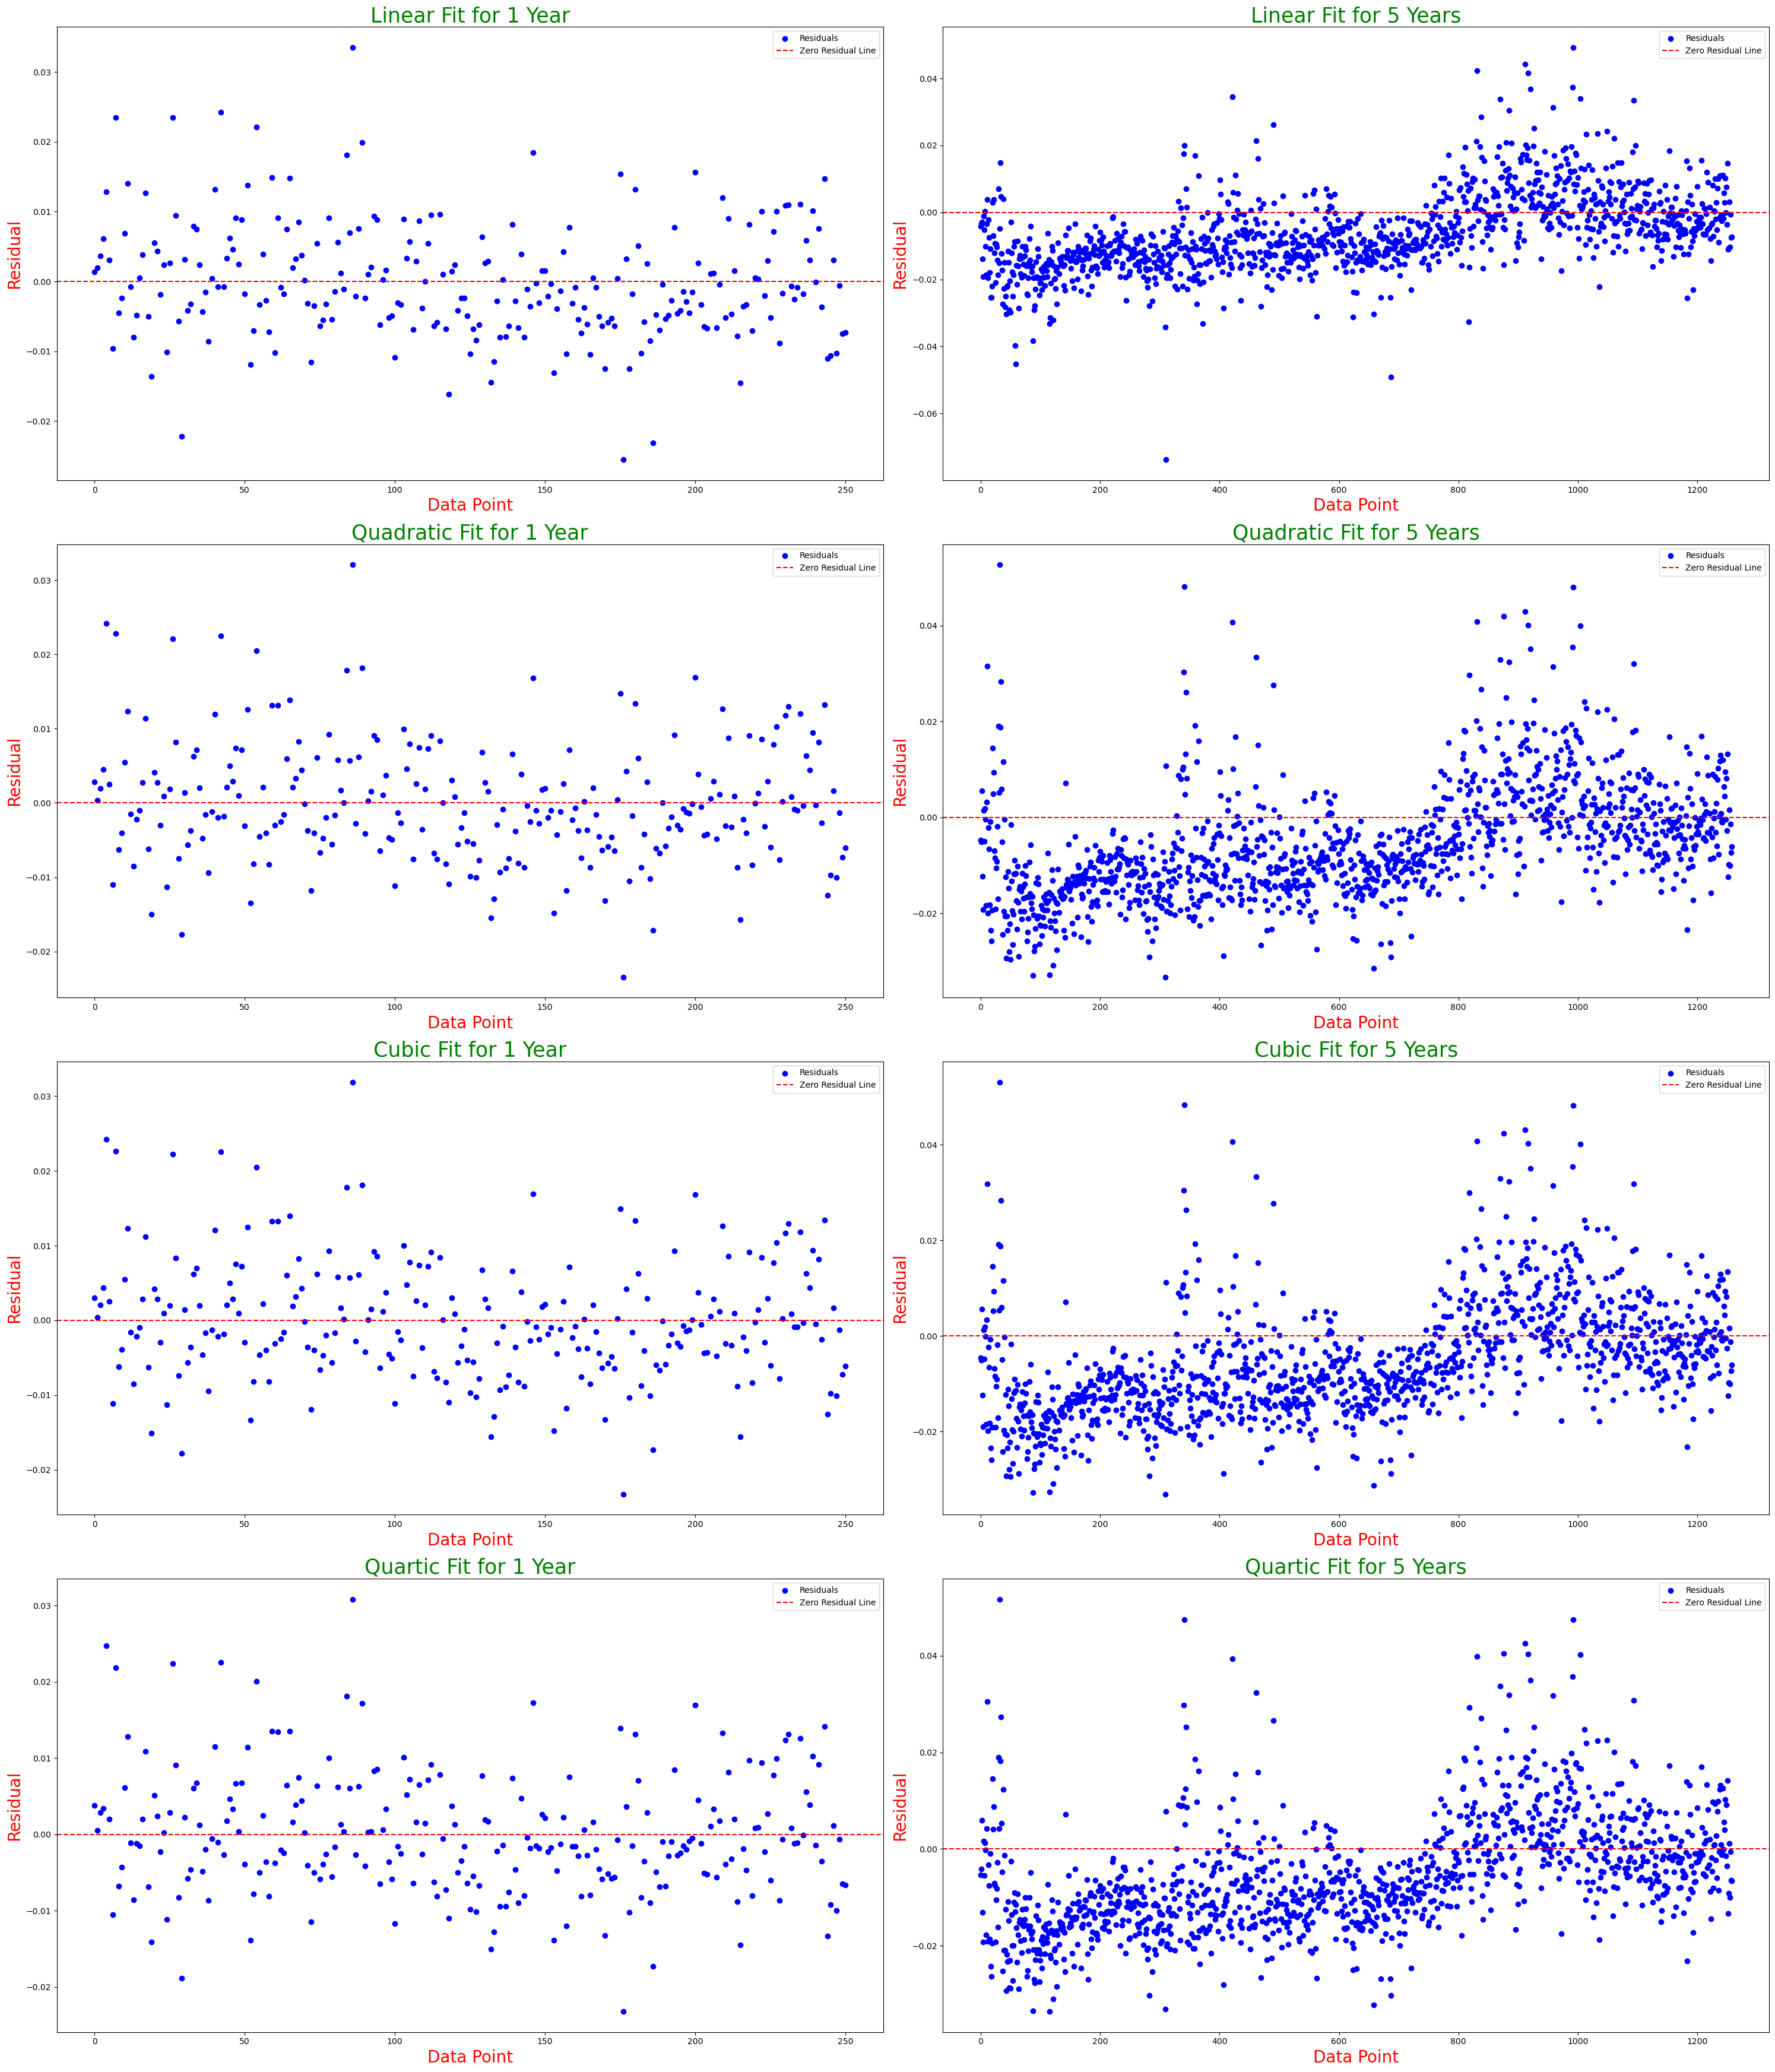

In [30]:
# Residual plots
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_linearfit.predicted_values(amzn_1y, lin_a, lin_b)).residual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_linearfit.predicted_values(amzn_5y, lin_a, lin_b)).residual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_quadraticfit.predicted_values(amzn_1y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_quadraticfit.predicted_values(amzn_5y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_cubicfit.predicted_values(amzn_1y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_cubicfit.predicted_values(amzn_5y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_1y.Volatility, predicted_values=amzn_quarticfit.predicted_values(amzn_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=amzn_5y.Volatility, predicted_values=amzn_quarticfit.predicted_values(amzn_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


The distance from the line at 0 is how bad the prediction was for that value.

| Fit | Observation |
| :- | :-: |
| Linear | In the residual plot for the 1-year period, the data points are evenly distributed around the zero line. However, in the 5-year residual plot, a significant shift is observed. Initially, the residuals are below the zero line, but as time progresses, they shift above it, without displaying a clear pattern. This indicates a greater level of variability in the residuals as the time frame extends to 5 years. One possible solution that is often effective in such cases is to consider variable transformation. Additionally, this shift may also suggest the possibility of a missing variable or factor that could be influencing the data.|
| Quadratic | In the residual plot for the 1-year period, the data points are evenly distributed around the zero line. However, in the 5-year residual plot, a significant shift is observed. Initially, the residuals are below the zero line, but as time progresses, they shift above it, without displaying a clear pattern. There are also a lot of datapoints which are too far from the zero line. This cannot be seen in the Linear Fit. This indicates a greater level of variability in the residuals as the time frame extends to 5 years. One possible solution that is often effective in such cases is to consider variable transformation. Additionally, this shift may also suggest the possibility of a missing variable or factor that could be influencing the data.|
| Cubic |  In the residual plot for the 1-year period, the data points are evenly distributed around the zero line. However, in the 5-year residual plot, a significant shift is observed. Initially, the residuals are below the zero line, but as time progresses, they shift above it, without displaying a clear pattern. There are also a lot of datapoints which are too far from the zero line. This cannot be seen in the Linear Fit. This indicates a greater level of variability in the residuals as the time frame extends to 5 years. One possible solution that is often effective in such cases is to consider variable transformation. Additionally, this shift may also suggest the possibility of a missing variable or factor that could be influencing the data.|
| Quartic | In the residual plot for the 1-year period, the data points are evenly distributed around the zero line. However, in the 5-year residual plot, a significant shift is observed. Initially, the residuals are below the zero line, but as time progresses, they shift above it, without displaying a clear pattern. There are also a lot of datapoints which are too far from the zero line. This cannot be seen in the Linear Fit. This indicates a greater level of variability in the residuals as the time frame extends to 5 years. One possible solution that is often effective in such cases is to consider variable transformation. Additionally, this shift may also suggest the possibility of a missing variable or factor that could be influencing the data. |

In [31]:
# Create an empty DataFrame
fit_eval = pd.DataFrame(columns=['Fit Type', 'Symbol', 'Period', 'RMSE', 'R2'])

# Define the data for the new row
linear_1Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'AMZN',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_linearfit.predicted_values(amzn_1y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_linearfit.predicted_values(amzn_1y, lin_a, lin_b)).calculate_r2()
}
# Define the data for the new row
linear_5Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'AMZN',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_linearfit.predicted_values(amzn_5y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_linearfit.predicted_values(amzn_5y, lin_a, lin_b)).calculate_r2()
}

quad_1Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'AMZN',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_quadraticfit.predicted_values(amzn_1y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_quadraticfit.predicted_values(amzn_1y, quad_a, quad_b, quad_c)).calculate_r2()
}
quad_5Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'AMZN',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_quadraticfit.predicted_values(amzn_5y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_quadraticfit.predicted_values(amzn_5y, quad_a, quad_b, quad_c)).calculate_r2()
}

cub_1Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'AMZN',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_cubicfit.predicted_values(amzn_1y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_cubicfit.predicted_values(amzn_1y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}
cub_5Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'AMZN',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_cubicfit.predicted_values(amzn_5y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_cubicfit.predicted_values(amzn_5y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}

quar_1Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'AMZN',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_quarticfit.predicted_values(amzn_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_1y.Volatility,predicted_values=amzn_quarticfit.predicted_values(amzn_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}
quar_5Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'AMZN',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_quarticfit.predicted_values(amzn_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=amzn_5y.Volatility,predicted_values=amzn_quarticfit.predicted_values(amzn_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}


# Add the new row to the DataFrame
fit_eval = fit_eval.append([linear_1Y,linear_5Y, quad_1Y, quad_5Y, cub_1Y, cub_5Y, quar_1Y, quar_5Y], ignore_index=True)

fit_eval


Fit Type Symbol Period      RMSE        R2
0     Linear   AMZN     1Y  0.008227  0.408023
1     Linear   AMZN     5Y  0.012979  0.131031
2  Quadratic   AMZN     1Y  0.008068  0.430606
3  Quadratic   AMZN     5Y  0.012971  0.132001
4      Cubic   AMZN     1Y  0.008068  0.430709
5      Cubic   AMZN     5Y  0.012980  0.130822
6    Quartic   AMZN     1Y  0.008042  0.434260
7    Quartic   AMZN     5Y  0.012956  0.134025

|FIT|OBSERVATION|BETTER OR WORSE FIT|
|:-|:-:|-:|
|Linear| The Linear model's performance declines with an increased RMSE and a really low R2. This suggests larger prediction errors and reduced explanatory power in the longer time frame. This could be attributed to the data being widely dispersed over the 5-year time period. There are a lot of outliers in the data, scaling can help make our model perform better. |Worse Fit|
|Quadratic|The Quadratic model's performance declines with an increased RMSE and a really low R2. This suggests larger prediction errors and reduced explanatory power in the longer time frame. This could be attributed to the data being widely dispersed over the 5-year time period.|Worse Fit|
|Cubic|RMSE increases and R2 decreases. This could be attributed to the data being widely dispersed over the 5-year time period.|Worse Fit|
|Quartic|RMSE increases and R2 decreases. This could be attributed to the data being widely dispersed over the 5-year time period.|Worse Fit|

### UBER

In [32]:
# Checking the plot of UBER
uber = HandleDataFrame('UBER')

In [33]:
# Load UBER 1 year data
uber_1y = uber.load_data("1Y")
uber_1y = uber.calculate_volatility_volume(uber_1y)
uber_1y.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2022-11-04  29.440001  29.725000  28.040001  28.389999  28.389999  22304200   
2022-11-07  28.705000  28.825001  27.615000  27.690001  27.690001  19204100   
2022-11-08  27.570000  28.330000  26.820000  27.440001  27.440001  27033900   
2022-11-09  27.309999  28.004999  26.440001  26.549999  26.549999  21186300   
2022-11-10  28.379999  29.320000  28.100000  28.850000  28.850000  35196900   

            Volatility  Volume_delta  Volatility_delta  
Date                                                    
2022-11-04    0.059352    -3100100.0         -0.015654  
2022-11-07    0.043698    -3100100.0         -0.015654  
2022-11-08    0.055029     7829800.0          0.011331  
2022-11-09    0.058945    -5847600.0          0.003916  
2022-11-10    0.042288    14010600.0         -0.016658

In [34]:
# Load UBER 5 year data
uber_5y = uber.load_data("5Y")
uber_5y = uber.calculate_volatility_volume(uber_5y)
uber_5y.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-05-10  42.000000  45.000000  41.060001  41.570000  41.570000  186322500   
2019-05-13  38.790001  39.240002  36.080002  37.099998  37.099998   79442400   
2019-05-14  38.310001  39.959999  36.849998  39.959999  39.959999   46661100   
2019-05-15  39.369999  41.880001  38.950001  41.290001  41.290001   36086100   
2019-05-16  41.480000  44.060001  41.250000  43.000000  43.000000   38115500   

            Volatility  Volume_delta  Volatility_delta  
Date                                                    
2019-05-10    0.094780  -106880100.0         -0.009605  
2019-05-13    0.085175  -106880100.0         -0.009605  
2019-05-14    0.077828   -32781300.0         -0.007347  
2019-05-15    0.070961   -10575000.0         -0.006866  
2019-05-16    0.065349     2029400.0         -0.005613

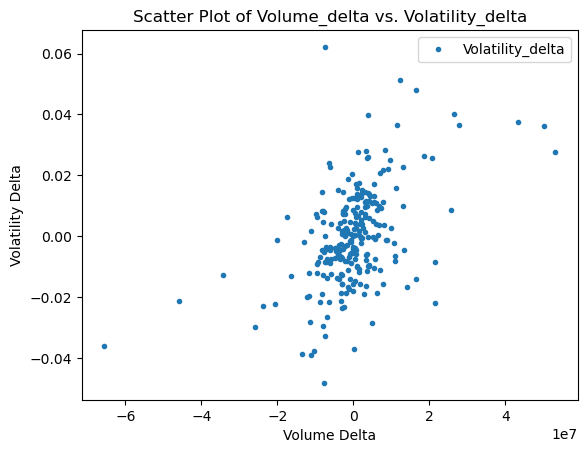

In [35]:
# Plot Volume_delta and Volatility_delta for 1Y
uber.plot_delta(uber_1y)

Our Linear Fit Equation is y = 5.870661600100231e-10 * x + 0.02058429766152273 

Our Quadratic Fit Equation is y = -3.61395325369203e-18 * x**2 + 9.166319222643152e-10 * x + 0.015612086535995339 

Our Cubic Fit Equation is y = 1.1628623905012144e-23 * x**3 + -3.591114417391645e-18 * x**2 + :9.139845603745285e-10 * x + 0.015658093318074547 

Our Quartic Fit Equation is y = -5.713427564990919e-23 * x**4 + 8.131141672333833e-24 * x**3 + :-3.612808198704064e-18 * x**2 + 9.148636888609147e-10 * x + 0.015636241270682024 



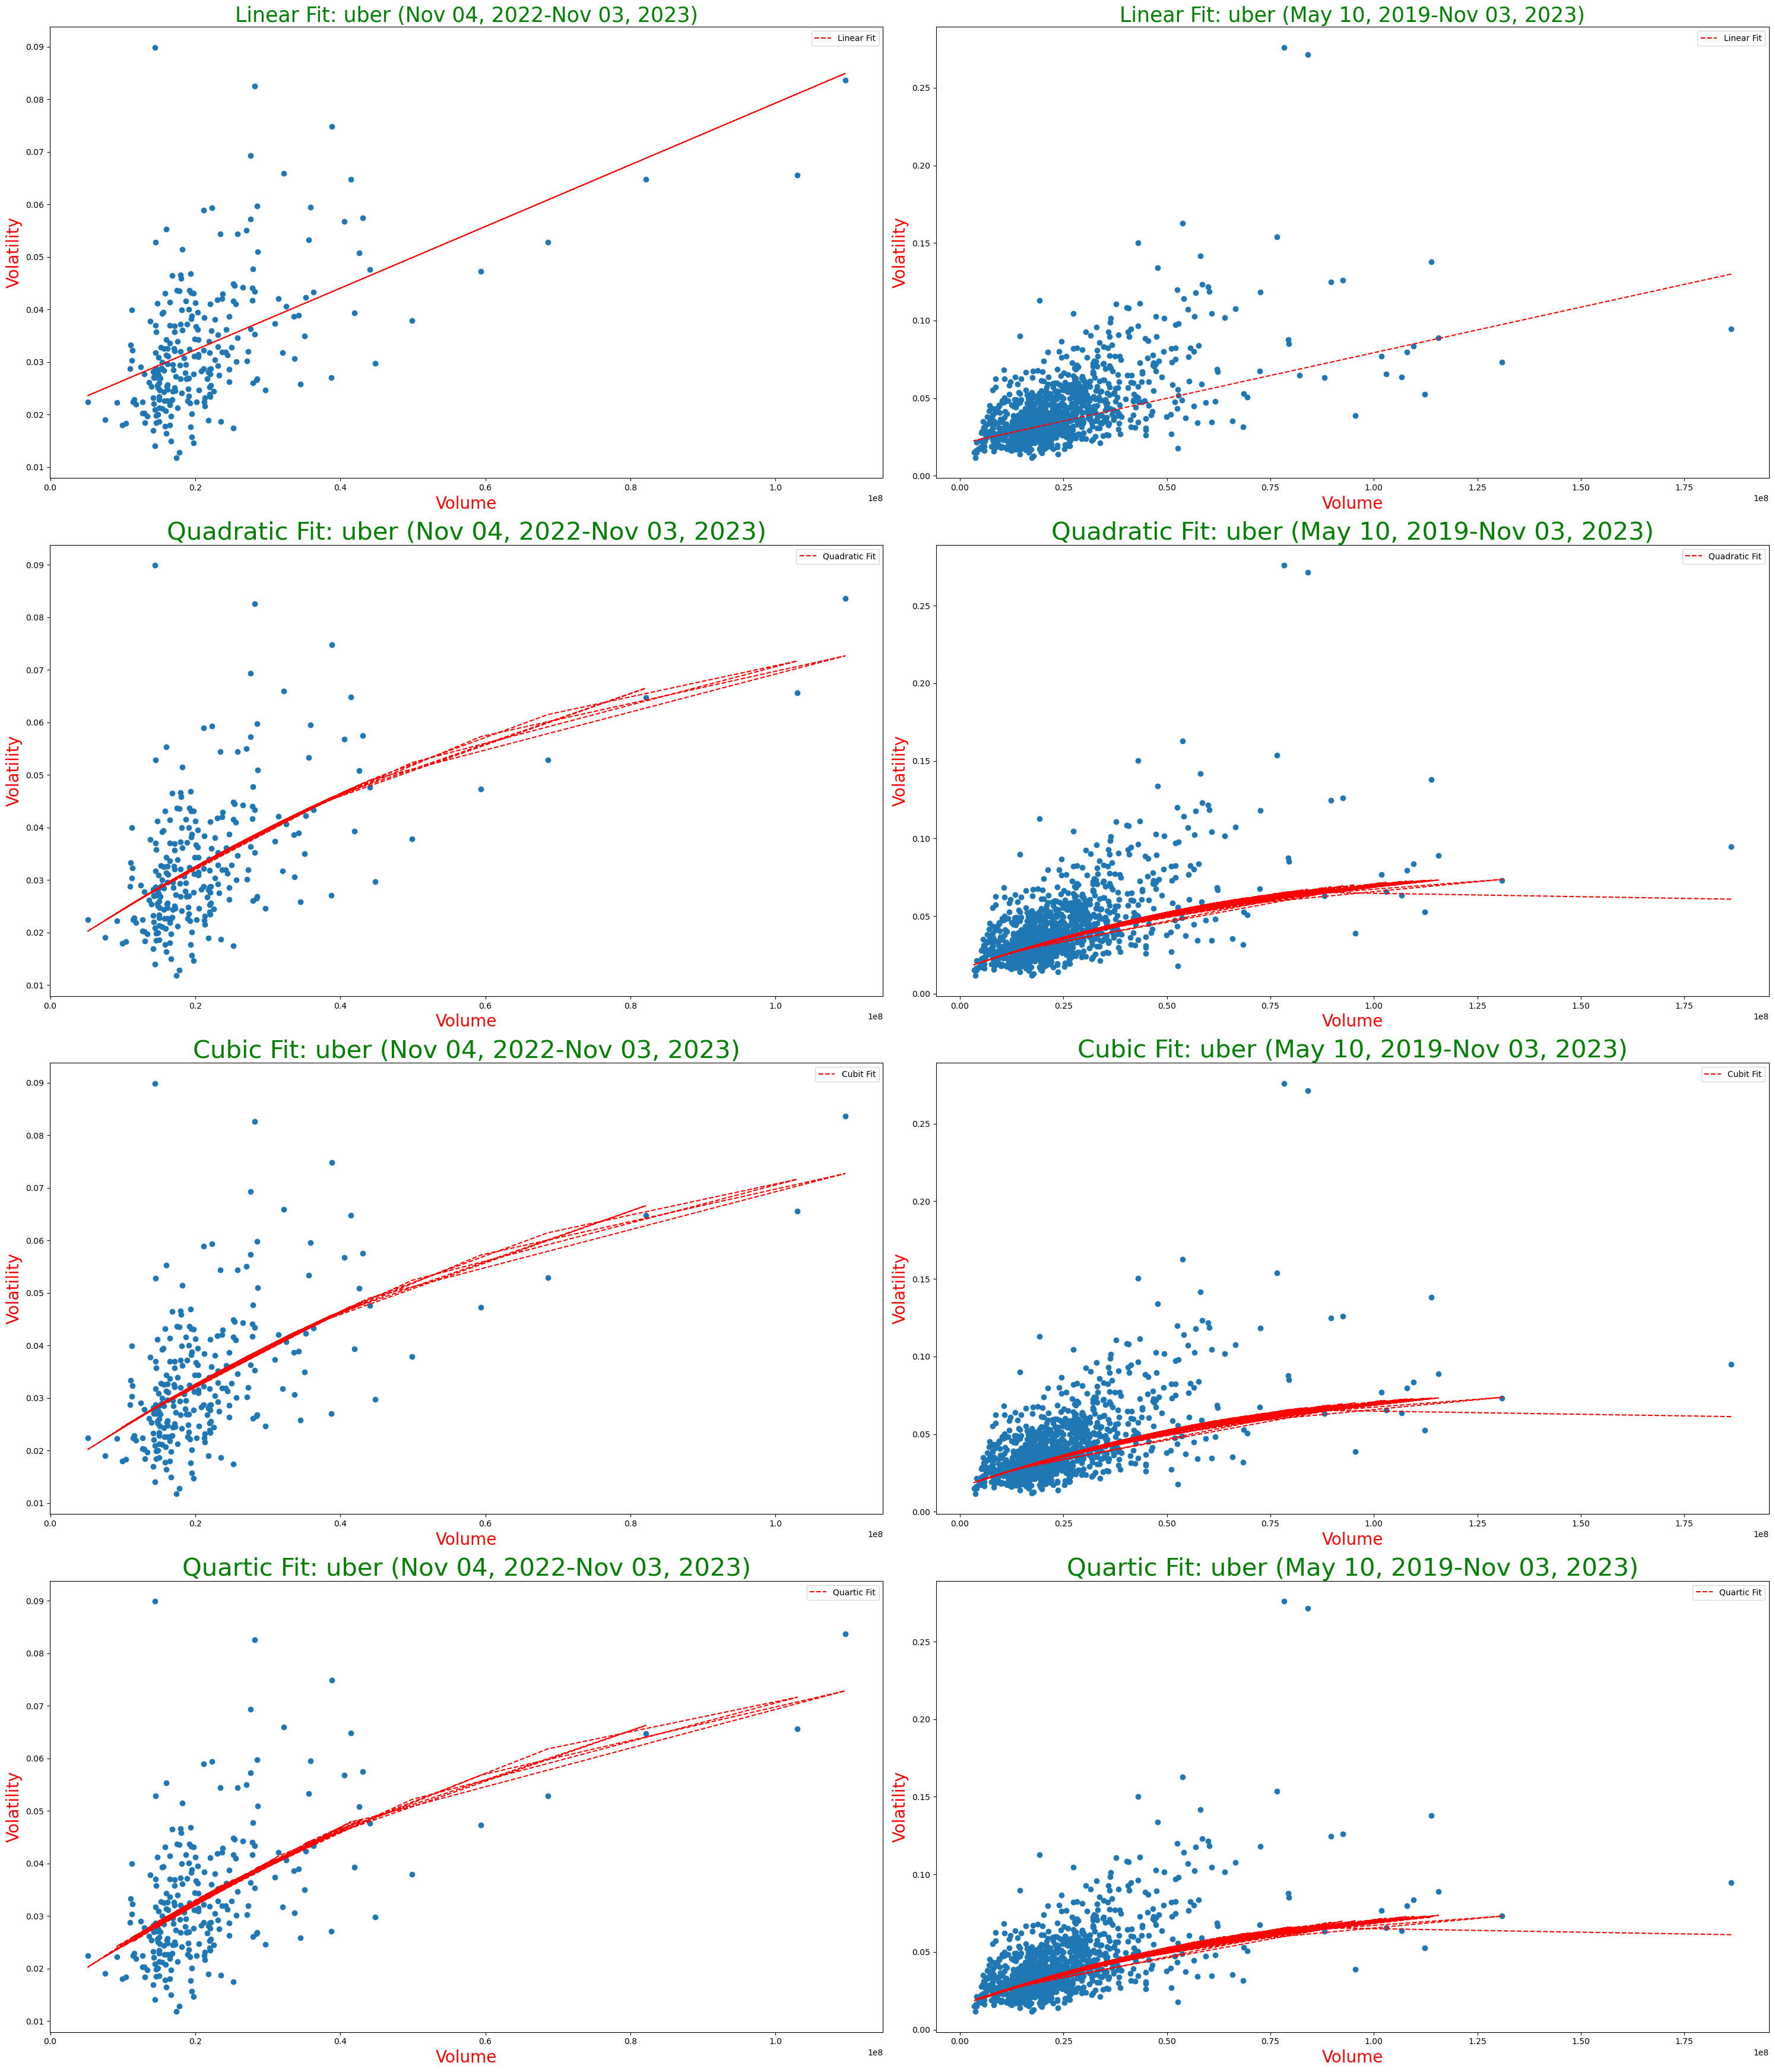

In [36]:
# uber 1Y Linear equation
uber_linearfit = Linear(uber_1y,'uber')
lin_a, lin_b = uber_linearfit.linear_fit()
print(f"Our Linear Fit Equation is y = {lin_a} * x + {lin_b} \n")

# uber 1Y Quadratic equation
uber_quadraticfit = Quadratic(uber_1y,'uber')
quad_a, quad_b, quad_c = uber_quadraticfit.quadratic_fit()
# Print the equation
print(f"Our Quadratic Fit Equation is y = {quad_a} * x**2 + {quad_b} * x + {quad_c} \n")

# uber 1Y Cubic equation
uber_cubicfit = Cubic(uber_1y,'uber')
cub_a, cub_b, cub_c, cub_d = uber_cubicfit.cubic_fit()
print(f"Our Cubic Fit Equation is y = {cub_a} * x**3 + {cub_b} * x**2 + :{cub_c} * x + {cub_d} \n")

# uber 1Y Quartic equation
uber_quarticfit = Quartic(uber_1y,'uber')
quar_a, quar_b, quar_c, quar_d, quar_e = uber_quarticfit.quartic_fit()
print(f"Our Quartic Fit Equation is y = {quar_a} * x**4 + {quar_b} * x**3 + :{quar_c} * x**2 + {quar_d} * x + {quar_e} \n")


# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Plot Linear Fit
plt.subplot(421)
uber_linearfit.plot_linear(uber_1y, lin_a, lin_b)

plt.subplot(422)
uber_linearfit.plot_linear(uber_5y, lin_a, lin_b)


# Plot Quadratic fit
plt.subplot(423)
uber_quadraticfit.plot_quadratic(uber_1y, quad_a, quad_b, quad_c)

plt.subplot(424)
uber_quadraticfit.plot_quadratic(uber_5y, quad_a, quad_b, quad_c)


# Plot Cubic fit
plt.subplot(425)
uber_cubicfit.plot_cubic(uber_1y, cub_a, cub_b, cub_c, cub_d)

plt.subplot(426)
uber_cubicfit.plot_cubic(uber_5y, cub_a, cub_b, cub_c, cub_d)


# Plot Quartic fit
plt.subplot(427)
uber_quarticfit.plot_quartic(uber_1y, quar_a, quar_b, quar_c, quar_d, quar_e)

plt.subplot(428)
uber_quarticfit.plot_quartic(uber_5y, quar_a, quar_b, quar_c, quar_d, quar_e)

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

| FIT | 1 YEAR | 5 YEARS | FINAL THOUGHTS |
| :- | :-: | :-: | :-: |
| Linear |It's apparent that the data points are tightly clustered on the graph. The linear fit line appears to neatly divide the data right in the center. | The data points are predominantly clustered towards the beginning of the graph, and there are notable outlier points. |While the linear fit line is performing reasonably, it doesn't excel to a significant extent.|
| Quadratic |It's apparent that the data points are tightly clustered on the graph. The quadratic fit line appears to neatly divide the data right in the center. | The data points are predominantly clustered towards the beginning of the graph, and there are notable outlier points. |While the quadratic fit line is performing reasonably, it doesn't excel to a significant extent.|
| Cubic |Cubic Fit shows similar pattern as quadratic fit equation.|Cubic Fit shows similar pattern as quadratic fit equation.| Cubic Fit is also not doing as well either. |
| Quartic |Quartic Fit shows similar pattern as quadratic fit equation.|Quartic Fit shows similar pattern as quadratic fit equation. |Quartic Fit is not doing as well.  |

Let's now check the Residual and Predicted vs Actual plots to analyse further.

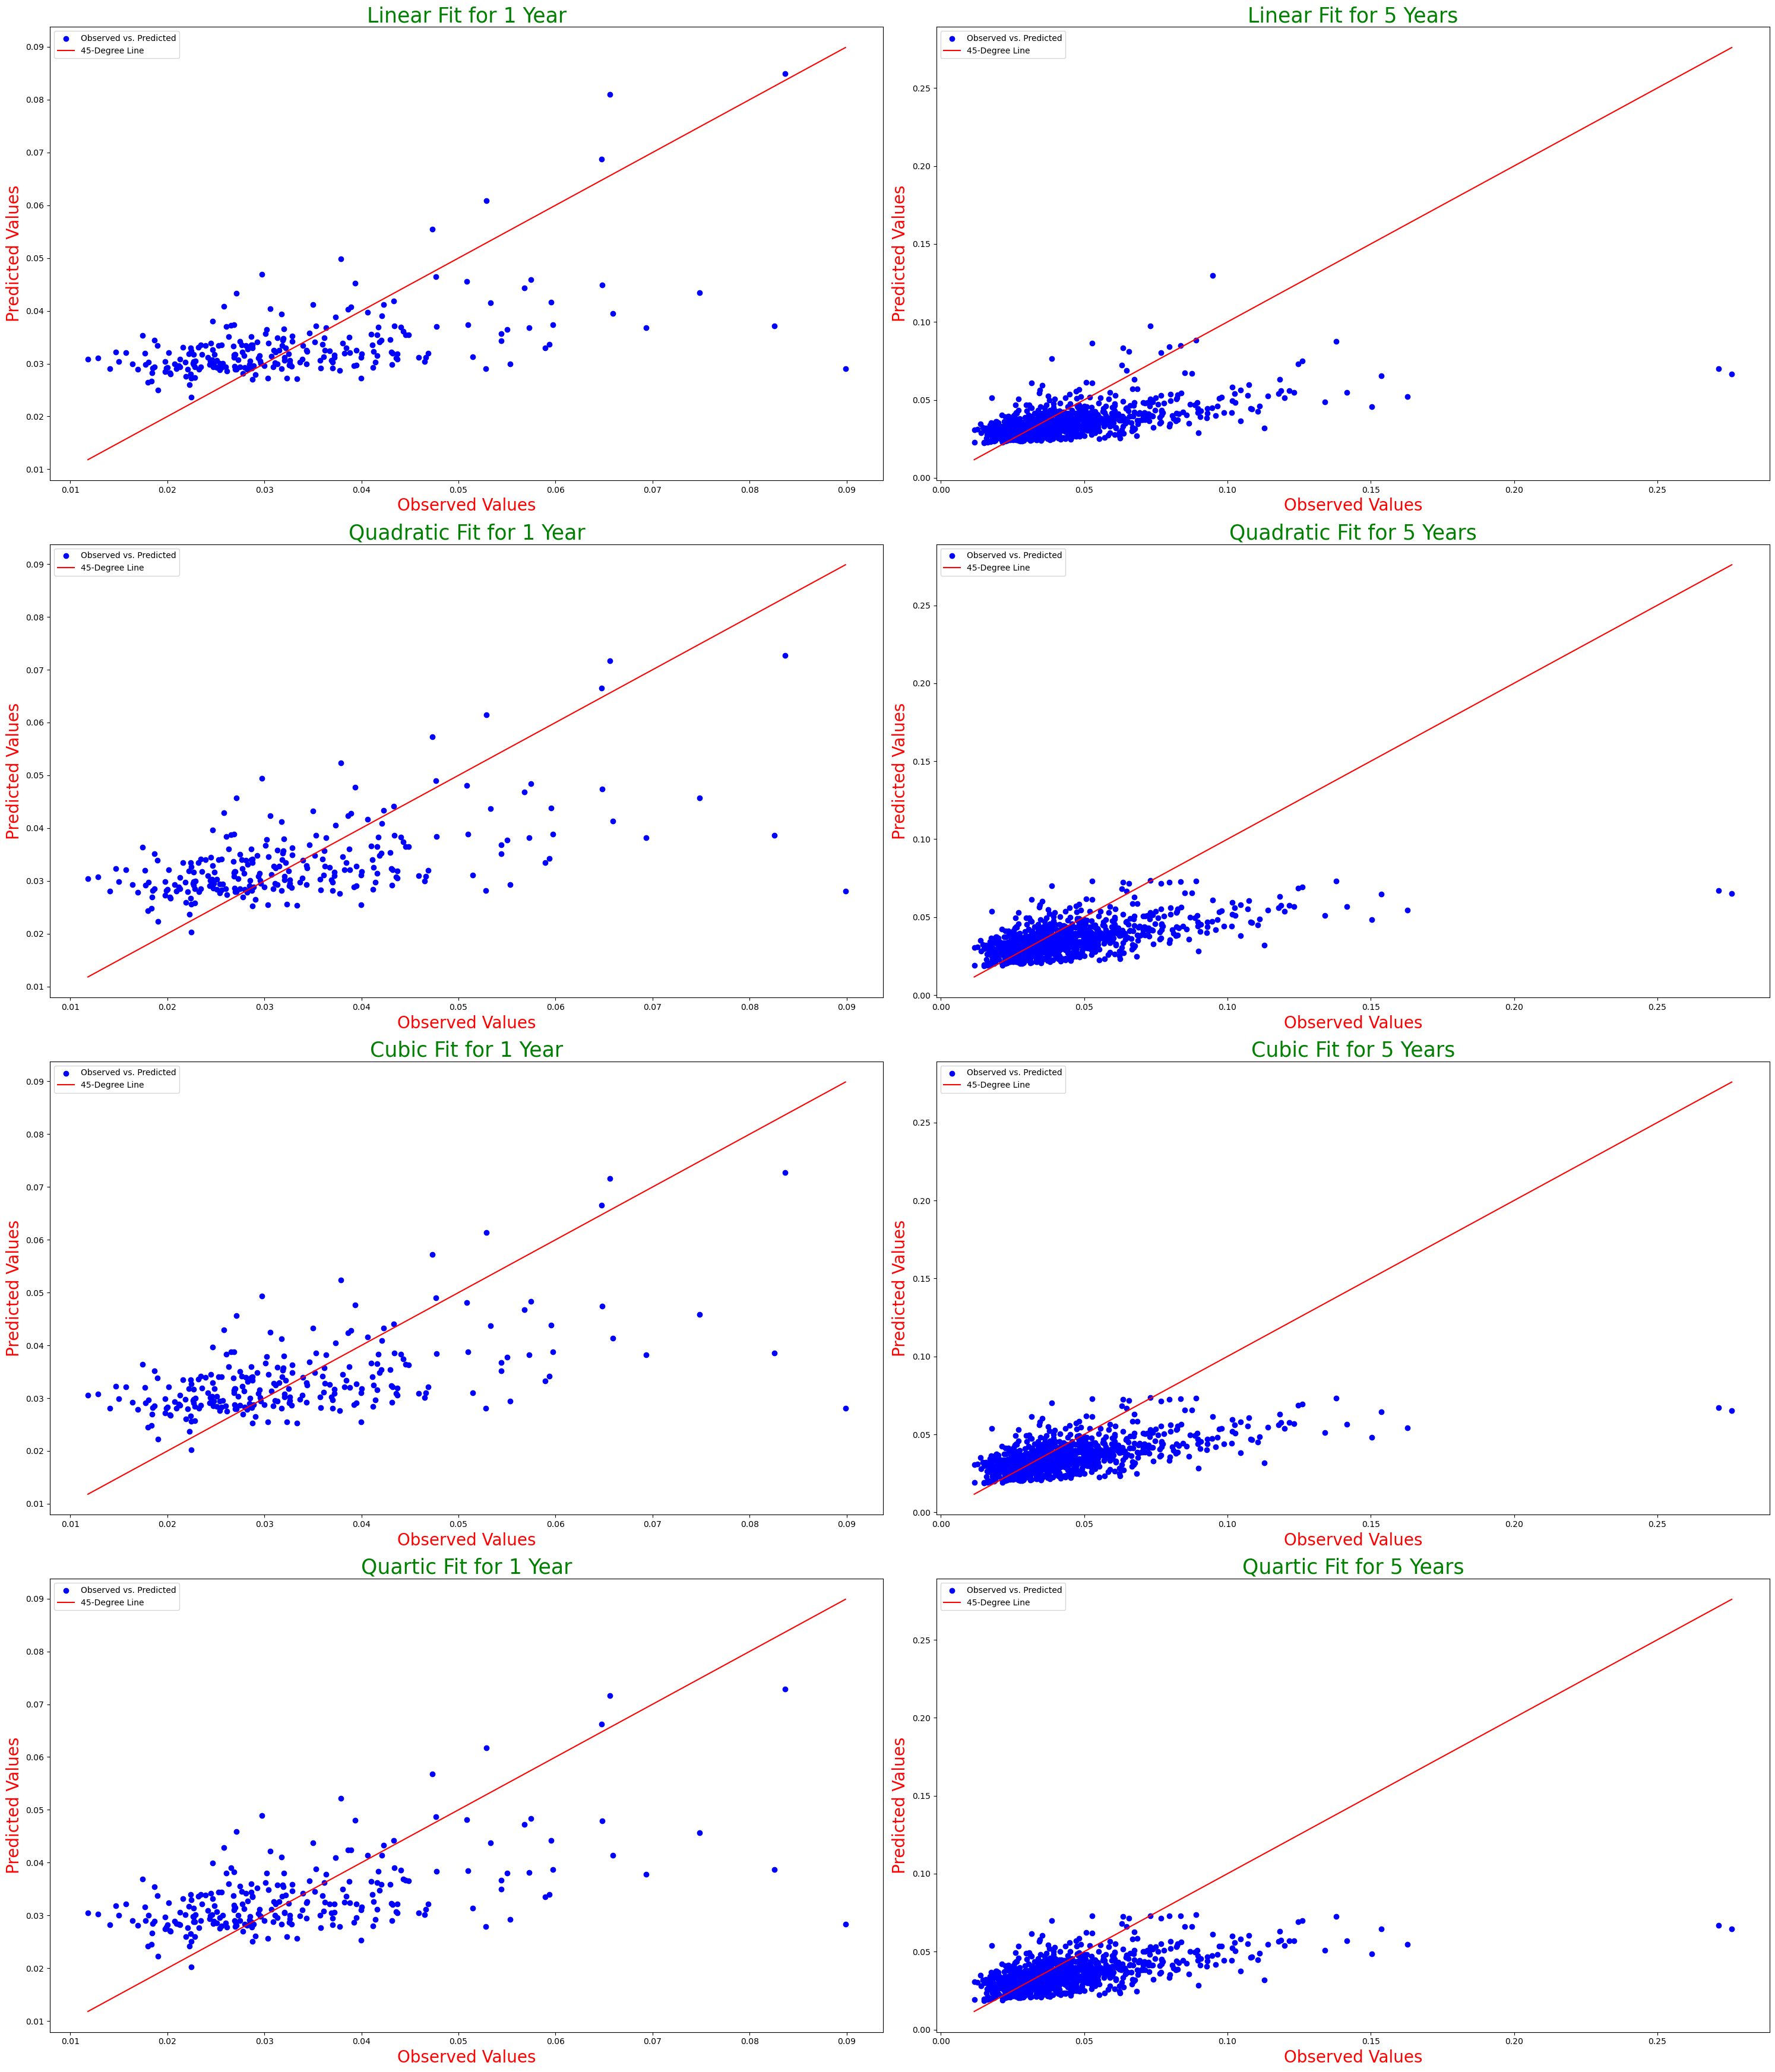

In [37]:
# Predicted vs Actual plot
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_linearfit.predicted_values(uber_1y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_linearfit.predicted_values(uber_5y, lin_a, lin_b)).pred_vs_actual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_quadraticfit.predicted_values(uber_1y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_quadraticfit.predicted_values(uber_5y, quad_a, quad_b, quad_c)).pred_vs_actual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_cubicfit.predicted_values(uber_1y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_cubicfit.predicted_values(uber_5y, cub_a, cub_b, cub_c, cub_d)).pred_vs_actual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_quarticfit.predicted_values(uber_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_quarticfit.predicted_values(uber_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).pred_vs_actual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


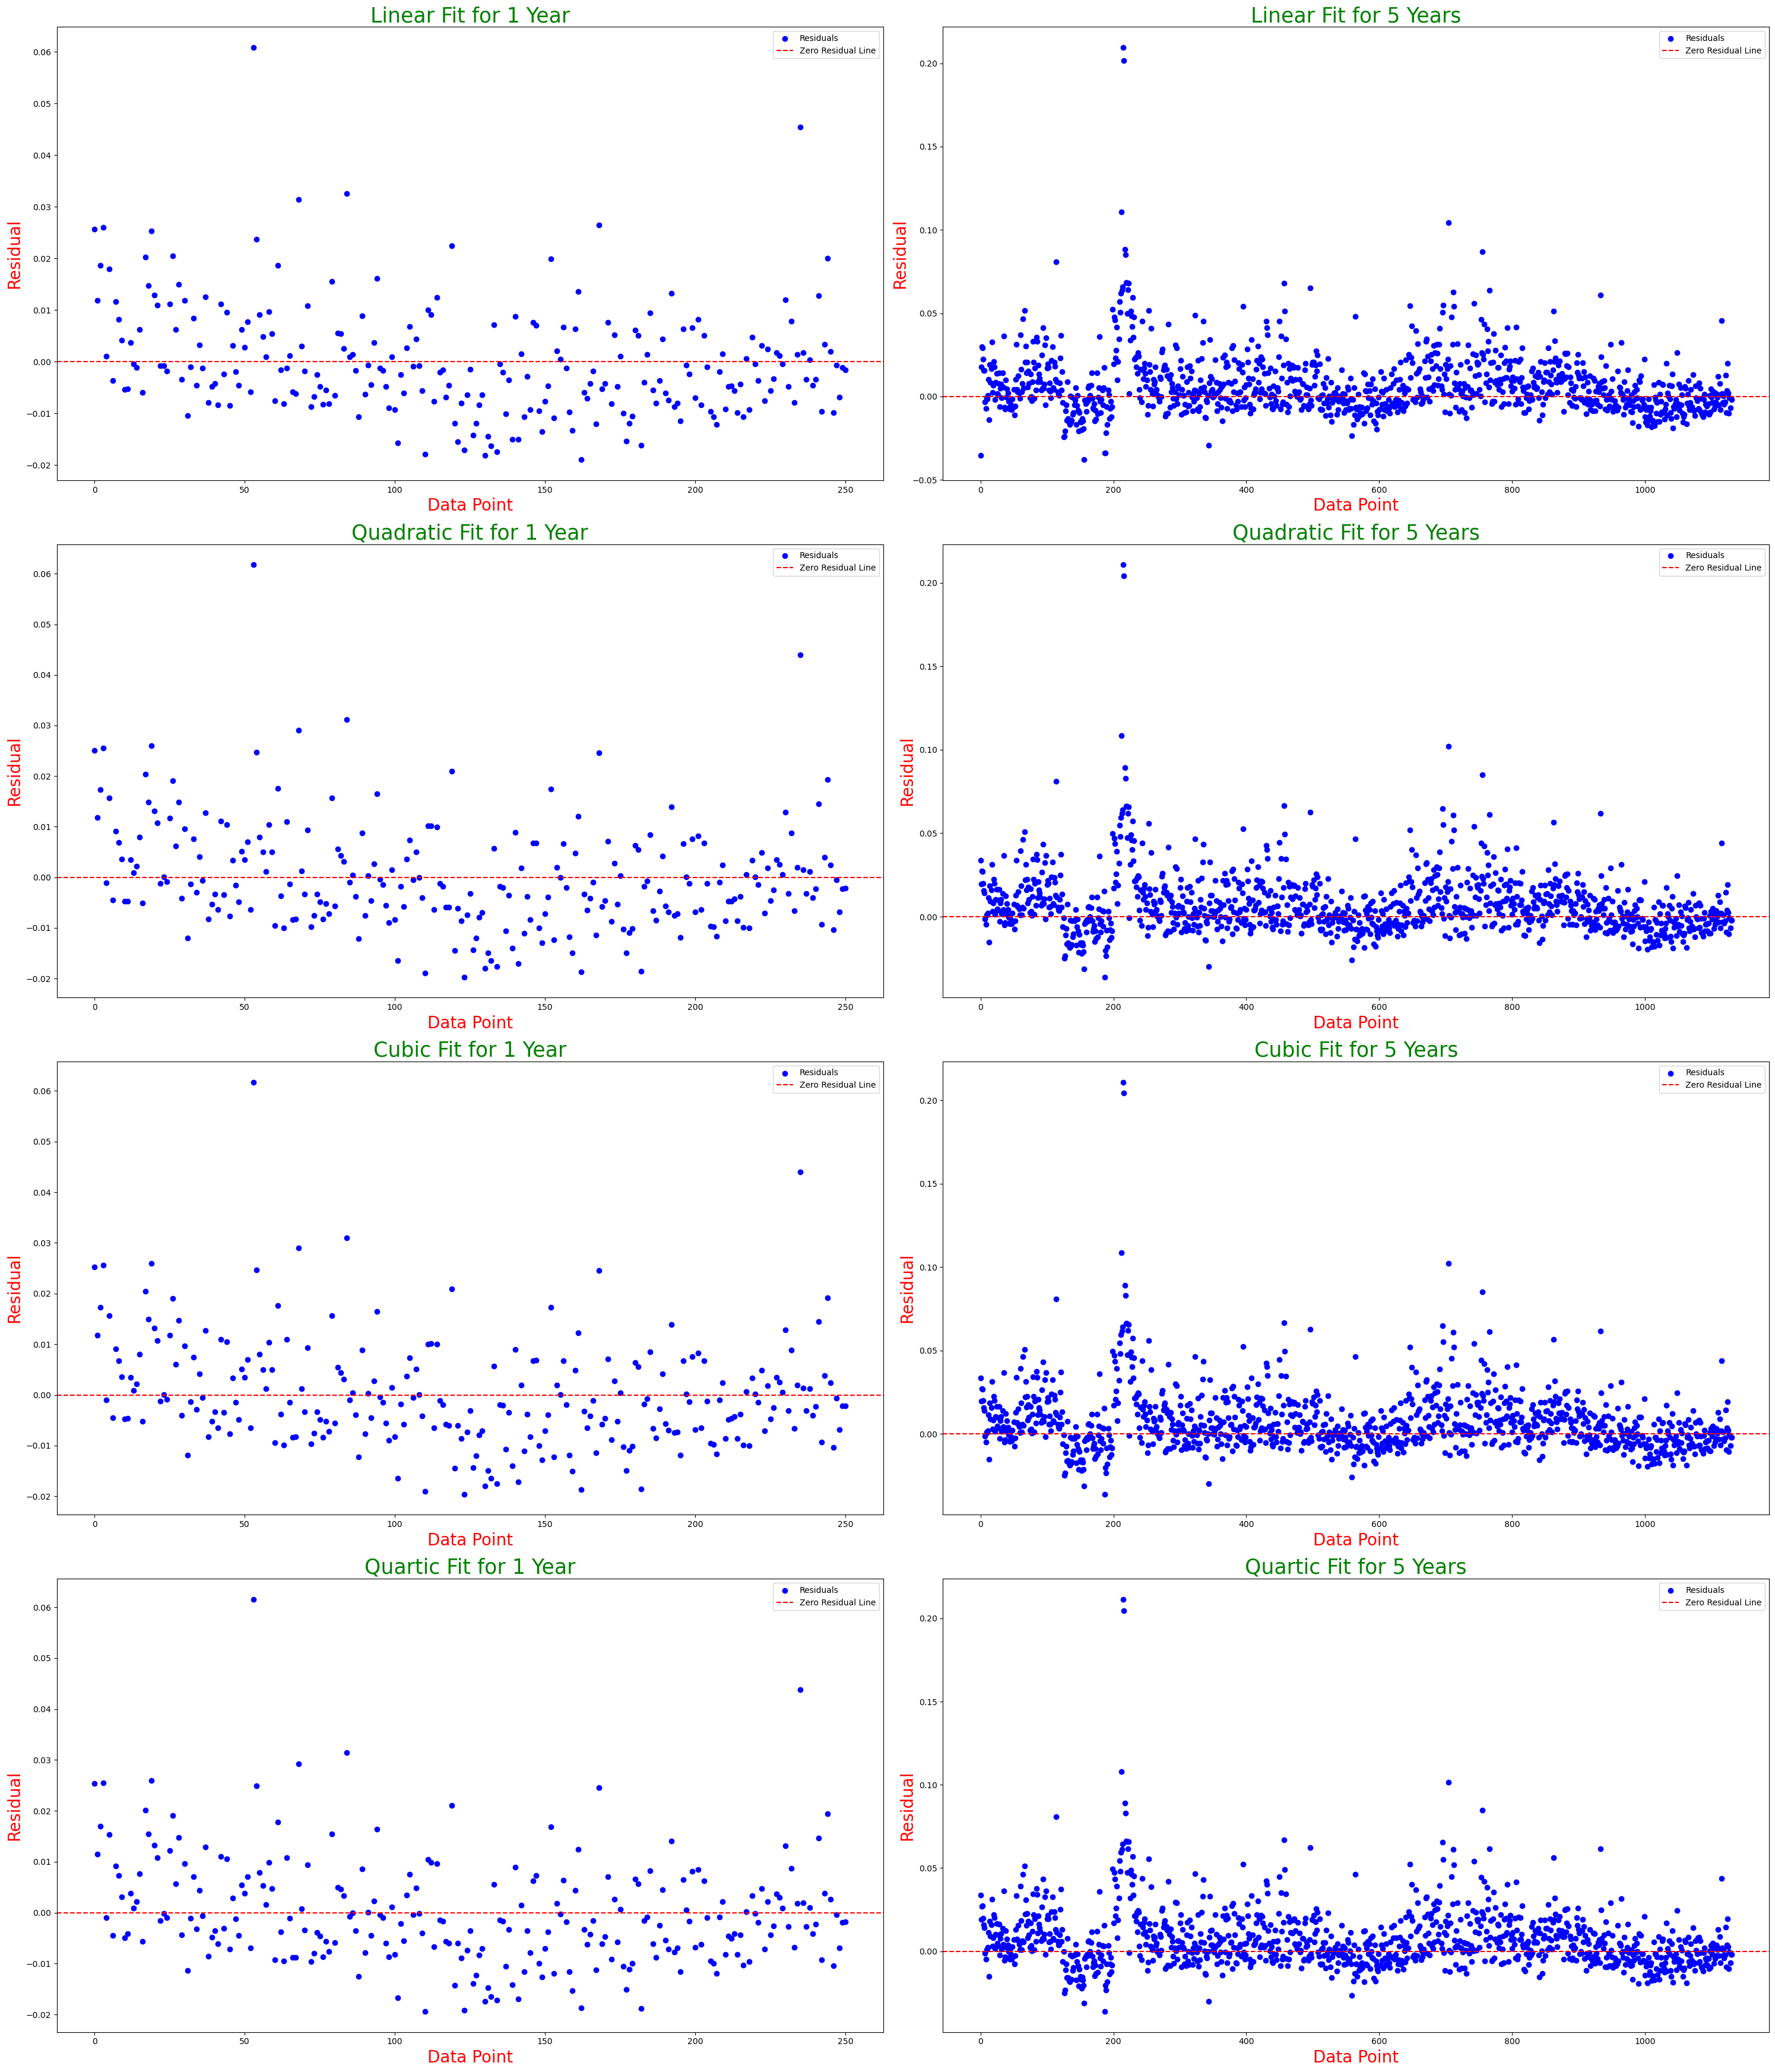

In [38]:
# Residual plots
# Create a figure with two subplots side by side
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

# Subplot 1: Linear Fit for 1 Year
axs[0, 0].set_title("Linear Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_linearfit.predicted_values(uber_1y, lin_a, lin_b)).residual_plot(ax=axs[0, 0])

# Subplot 2: Linear Fit for 5 Years
axs[0, 1].set_title("Linear Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_linearfit.predicted_values(uber_5y, lin_a, lin_b)).residual_plot(ax=axs[0, 1])

# Subplot 3: Quadratic Fit for 1 Year
axs[1, 0].set_title("Quadratic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_quadraticfit.predicted_values(uber_1y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 0])

# Subplot 4: Quadratic Fit for 5 Years
axs[1, 1].set_title("Quadratic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_quadraticfit.predicted_values(uber_5y, quad_a, quad_b, quad_c)).residual_plot(ax=axs[1, 1])

# Subplot 5: Cubic Fit for 1 Year
axs[2, 0].set_title("Cubic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_cubicfit.predicted_values(uber_1y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 0])

# Subplot 6: Cubic Fit for 5 Years
axs[2, 1].set_title("Cubic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_cubicfit.predicted_values(uber_5y, cub_a, cub_b, cub_c, cub_d)).residual_plot(ax=axs[2, 1])

# Subplot 7: Quartic Fit for 1 Year
axs[3, 0].set_title("Quartic Fit for 1 Year", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_1y.Volatility, predicted_values=uber_quarticfit.predicted_values(uber_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 0])

# Subplot 8: Quartic Fit for 5 Years
axs[3, 1].set_title("Quartic Fit for 5 Years", color = 'g', fontsize = 25)
Evaluation(observed_values=uber_5y.Volatility, predicted_values=uber_quarticfit.predicted_values(uber_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).residual_plot(ax=axs[3, 1])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


The distance from the line at 0 is how bad the prediction was for that value.

| Fit | Observation |
| :- | :-: |
| Linear | In the residual plot for the 1-year period, the data points are uniformly scattered around the zero line. Similarly, in the 5-year residual plot, most data points maintain an even distribution, except for a specific time period where a significant deviation from the zero line occurs. This anomaly could be attributed to external factors such as a market event, like a stock market crash, influencing the data.|
| Quadratic | In the residual plot for the 1-year period, the data points are uniformly scattered around the zero line. Similarly, in the 5-year residual plot, most data points maintain an even distribution, except for a specific time period where a significant deviation from the zero line occurs. This anomaly could be attributed to external factors such as a market event, like a stock market crash, influencing the data.|
| Cubic |  In the residual plot for the 1-year period, the data points are uniformly scattered around the zero line. Similarly, in the 5-year residual plot, most data points maintain an even distribution, except for a specific time period where a significant deviation from the zero line occurs. This anomaly could be attributed to external factors such as a market event, like a stock market crash, influencing the data.|
| Quartic | In the residual plot for the 1-year period, the data points are uniformly scattered around the zero line. Similarly, in the 5-year residual plot, most data points maintain an even distribution, except for a specific time period where a significant deviation from the zero line occurs. This anomaly could be attributed to external factors such as a market event, like a stock market crash, influencing the data.|

In [39]:
# Create an empty DataFrame
fit_eval = pd.DataFrame(columns=['Fit Type', 'Symbol', 'Period', 'RMSE', 'R2'])

# Define the data for the new row
linear_1Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'UBER',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_linearfit.predicted_values(uber_1y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_linearfit.predicted_values(uber_1y, lin_a, lin_b)).calculate_r2()
}
# Define the data for the new row
linear_5Y = {
    'Fit Type' : 'Linear',
    'Symbol': 'UBER',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_linearfit.predicted_values(uber_5y, lin_a, lin_b)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_linearfit.predicted_values(uber_5y, lin_a, lin_b)).calculate_r2()
}

quad_1Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'UBER',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_quadraticfit.predicted_values(uber_1y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_quadraticfit.predicted_values(uber_1y, quad_a, quad_b, quad_c)).calculate_r2()
}
quad_5Y = {
    'Fit Type' : 'Quadratic',
    'Symbol': 'UBER',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_quadraticfit.predicted_values(uber_5y, quad_a, quad_b, quad_c)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_quadraticfit.predicted_values(uber_5y, quad_a, quad_b, quad_c)).calculate_r2()
}

cub_1Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'UBER',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_cubicfit.predicted_values(uber_1y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_cubicfit.predicted_values(uber_1y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}
cub_5Y = {
    'Fit Type' : 'Cubic',
    'Symbol': 'UBER',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_cubicfit.predicted_values(uber_5y, cub_a, cub_b, cub_c, cub_d)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_cubicfit.predicted_values(uber_5y, cub_a, cub_b, cub_c, cub_d)).calculate_r2()
}

quar_1Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'UBER',
    'Period': '1Y',
    'RMSE': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_quarticfit.predicted_values(uber_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_1y.Volatility,predicted_values=uber_quarticfit.predicted_values(uber_1y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}
quar_5Y = {
    'Fit Type' : 'Quartic',
    'Symbol': 'UBER',
    'Period': '5Y',
    'RMSE': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_quarticfit.predicted_values(uber_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_rmse(),
    'R2': Evaluation(observed_values=uber_5y.Volatility,predicted_values=uber_quarticfit.predicted_values(uber_5y, quar_a, quar_b, quar_c, quar_d, quar_e)).calculate_r2()
}



# Add the new row to the DataFrame
fit_eval = fit_eval.append([linear_1Y,linear_5Y, quad_1Y, quad_5Y, cub_1Y, cub_5Y, quar_1Y, quar_5Y], ignore_index=True)

fit_eval


Fit Type Symbol Period      RMSE        R2
0     Linear   UBER     1Y  0.010729  0.294148
1     Linear   UBER     5Y  0.020293  0.215826
2  Quadratic   UBER     1Y  0.010627  0.307502
3  Quadratic   UBER     5Y  0.020016  0.237068
4      Cubic   UBER     1Y  0.010627  0.307524
5      Cubic   UBER     5Y  0.020021  0.236702
6    Quartic   UBER     1Y  0.010623  0.308072
7    Quartic   UBER     5Y  0.020023  0.236556

|FIT|OBSERVATION|BETTER OR WORSE FIT|
|:-|:-:|-:|
|Linear| The Linear model's performance declines, evidenced by an increased RMSE and a lower R2. This indicates larger prediction errors and reduced explanatory power when looking at the longer time frame. Comparatively, the Linear model is a slightly worse fit for the 5-year period compared to the 1-year period. |Slightly Worse Fit|
|Quadratic|The Quadratic model maintains decent performance, with a slightly increased RMSE and a slightly lower R2. While the performance is slightly reduced, it still offers a reasonable balance between prediction accuracy and explanatory power. Comparatively, the Quadratic model is a worse fit for the 5-year period, although it retains a decent performance.|Slightly Worse Fit|
|Cubic|The Cubic model's performance remains consistent, with slightly increased RMSE and a slightly lower R2. The model maintains a good ability to explain variance, although the prediction errors increase slightly. Comparatively, the Cubic model is a worse fit for the 5-year period, but it still offers reasonable performance.|Slightly Worse Fit|
|Quartic|The Quartic model continues to perform well, with an increased RMSE and a slightly lower R2 . The model maintains a strong ability to explain variance, although the prediction errors increase slightly. Comparatively, the Quartic model is a worse fit for the 5-year period, but it still demonstrates strong performance.|Slightly Worse Fit|